In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
from scipy.stats import norm
import pylab

from scipy.stats import shapiro

## Virtual machine trend

- pmd-small: predictability jikes > HotSpot > J9
- xalan-small: jikes > j9 > hotspot

In [2]:
trace_name = "pmd"

In [3]:
def plot_actual_predicted(trace_name, jvm):
    start_point = 10000
    n_points = 5000
    history_size = 40
    
    if jvm == "jikes":
        jvm_name = "JikesRVM"
    elif jvm == "j9":
        jvm_name = "J9"
    else:
        jvm_name = "HotSpot"
    
    trace = pd.read_pickle(
                '../data/{}-small-{}-d-l64-p4096-w100000i.analyzed-1.pkl'.format(trace_name, jvm_name)
            ).to_numpy()[start_point:start_point+n_points]
    
    for hidden_size in hidden_sizes:
        predictions = np.load(
                    'output_files/{}/{}/predictions_{}_{}_{}_{}.npy'.format(trace_name, jvm, 40, 1, hidden_size, 1))
        predictions = np.argsort(predictions)
        actual = []
        predicted = []

        for idx, point in enumerate(trace):
            actual.append(float(np.argmax(point)))
            predicted.append(predictions[history_size-1+idx, -1])

        n_points = 5000
        start_point = 0

        n_points = min(trace.shape[0]-start_point, n_points)

        plt.plot(range(start_point, start_point+n_points), actual, label='actual')
        plt.plot(range(start_point, start_point+n_points), predicted, label='predicted', alpha=0.7)
        plt.title("hidden size: {}".format(hidden_size))
        plt.legend()
        plt.show()
    
    return trace

In [4]:
def get_heatmaps(trace_name, trace, predictions, jvm="jikes"):
    prediction_map = {}
    
    hidden_sizes = [ 1, 2, 3, 4, 5, 6, 7, 8, 9, 
                10, 20, 30, 40, 50, 60, 70, 80, 90, 100,
                200, 300, 400, 500, 600, 700, 800, 900,
               1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000,
               9000, 10000, 11000, 12000, 13000, 14000, 15000,
                16000, 17000, 18000, 19000, 20000
               ]
    
    for hidden_size in hidden_sizes:
    #     hidden_size = 8000
        heatmap = np.zeros((predictions.shape[1], predictions.shape[1]))
        predictions = np.load(
                    'output_files/{}/{}/predictions_{}_{}_{}_{}.npy'.format(trace_name, 
                                                                            jvm, 40, 1, 
                                                                            hidden_size, 1))
        # predictions = np.argsort(predictions)

        heatmap[predictions.shape[1]-1, 0] = 0
        heatmap[0, 0] = 0

        for idx, point in enumerate(trace):
        #     print(predictions[history_size-1+idx, -1])
        #     print("{}, {}: {}".format(history_size, np.argmax(point), int(predictions[history_size-1+idx, -1])))
            heatmap[np.argmax(point), int(np.argsort(predictions[history_size-1+idx].flatten())[-1])] += 1

        prediction_map[hidden_size] = heatmap.copy()

        heatmap += 1e-50
        # print(np.sum(heatmap>1))
        # print(np.sum(heatmap, axis=0))
        heatmap = heatmap/np.sum(heatmap, axis=0)
        heatmap = heatmap*1000

        plt.xlabel("predicted")
        plt.ylabel("actual")
        plt.title("hidden layer size = {}".format(hidden_size))
        plt.imshow(heatmap, cmap='seismic', interpolation='nearest')
        plt.tight_layout()
    #     plt.savefig("output_files/plots/heatmap_{}.jpg".format(hidden_size), dpi=500)
        plt.show()
    
    return prediction_map

In [5]:
def compute_prec_recall_curves(prediction_map):
    tolerance = 3
    avg_f1_list = []
    avg_precision_list = []
    avg_recall_list = []

    hidden_sizes = [ 1, 2, 3, 4, 5, 6, 7, 8, 9, 
                10, 20, 30, 40, 50, 60, 70, 80, 90, 100,
                200, 300, 400, 500, 600, 700, 800, 900,
               1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000,
               9000, 10000, 11000, 12000, 13000, 14000, 15000,
                16000, 17000, 18000, 19000, 20000
               ]
    
    for hidden_size in hidden_sizes:
        predictions = prediction_map[hidden_size]

        precision_list = []
        recall_list = []
        f1_list = []

        for bin_idx in range(100):
            tp = np.sum(predictions[bin_idx-tolerance:bin_idx+tolerance, bin_idx-tolerance:bin_idx+tolerance])

            tn = predictions.copy()
            tn[bin_idx - tolerance:bin_idx + tolerance, :] = 0
            tn[:, bin_idx - tolerance:bin_idx + tolerance] = 0
            tn = np.sum(tn)

            fp = predictions.copy()
            fp = fp[:, bin_idx-tolerance:bin_idx+tolerance]
            fp[bin_idx-tolerance: bin_idx+tolerance, :] = 0
            fp = np.sum(fp)

            fn = predictions.copy()
            fn = fn[bin_idx-tolerance:bin_idx+tolerance]
            fn[:, bin_idx-tolerance:bin_idx+tolerance] = 0
            fn = np.sum(fn)

            precision = 0
            if tp+fp != 0:
                precision = tp/(tp+fp)

            recall = 0
            if tp+fn != 0:
                recall = tp/(tp+fn)

            f1_score = 0

            if precision + recall != 0:
                f1_score = 2 * precision * recall / (precision+recall)

            precision_list.append(precision)
            recall_list.append(recall)
            f1_list.append(f1_score)

        avg_precision_list.append(np.average(precision_list))
        avg_recall_list.append(np.average(recall_list))
        avg_f1_list.append(np.average(f1_list))

        plt.figure(num=None, figsize=(10, 2), dpi=80, facecolor='w', edgecolor='k')

        plt.subplot(131)
        plt.plot(range(100), precision_list)
        plt.xlabel("bin index")
        plt.ylabel("precision")
        plt.ylim((-0.1, 1.1))

        plt.subplot(132)
        plt.plot(range(100), recall_list)
        plt.xlabel("bin index")
        plt.ylabel("recall")
        plt.ylim((-0.1, 1.1))

        plt.subplot(133)
        plt.plot(range(100), f1_list)
        plt.xlabel("bin index")
        plt.ylabel("f1_score")
        plt.ylim((-0.1, 1.1))

        plt.title("hidden size: {}".format(hidden_size))
        plt.show()
    
    return avg_precision_list, avg_recall_list, avg_f1_list

In [379]:
def get_distribution(loss_array):
#     print(loss_array)
#     print(loss_array.shape)
#     f = loss_array.flatten()
    f=np.sum(loss_array, axis=1)/loss_array.shape[1]
    f = f.flatten()
    print(f)
    plt.hist(f, bins='auto')
    plt.xlim(0, 0.12)
    plt.show()
    
    return f

In [380]:
def sup(arr, mode="max"):
    if mode == "max":
        return (max(arr))
    elif mode == "999percentile":
        return np.mean(arr) + 5 * np.std(arr)
    

def get_rademacher(loss_array):
    rademacher = []
    
    n_sigma = 2000
    
    for i in range(n_sigma):
        sigma_arr = np.random.choice([-1, 1], size=loss_array.shape)

        f = sigma_arr*loss_array
        f = np.sum(f, axis=1)/loss_array.shape[1]
        # print(f)
        rademacher.append(sup(f))
    
    return np.mean(rademacher)


def get_mod_rademacher(loss_array):
    rademacher = []
    
    n_sigma = 2000
    
    for i in range(n_sigma):
        sigma_arr = np.random.choice([-1, 1], size=loss_array.shape)

        f = sigma_arr*loss_array
        f = np.sum(f, axis=1)/loss_array.shape[1]
        # print(f)
        rademacher.append(sup(f, mode="999percentile"))
    
    return np.mean(rademacher)

In [381]:
print("max: ", np.max(np.load("output_files/{}/jikes/loss_40_1_1.npy".format(trace_name))))
print("min: ", np.max(np.load("output_files/{}/jikes/loss_40_80_1.npy".format(trace_name))))

max:  0.11695129424333572
min:  0.008311459794640541


In [382]:
## ks statistic = closer to zero values are better
## p_value > 0.05, accept normal
my_data = norm.rvs(size=1000)

print(shapiro(my_data))

(0.9984962344169617, 0.5521813631057739)


In [383]:
# loss = np.load("output_files/jikes/loss_40_1_1.npy")
# dist = get_distribution(loss)

# print(shapiro(dist))
# print("mean: {}, std: {}".format(np.mean(dist), np.std(dist)))
# print("Rademacher: {}".format(get_rademacher(loss)))
# print("Modified Rademacher: {}".format(get_mod_rademacher(loss)))

In [7]:
hidden_sizes = [ 1, 2, 3, 4, 5, 6, 7, 8, 9, 
                10, 20, 30, 40, 50, 60, 70, 80, 90, 100,
                200, 300, 400, 500, 600, 700, 800, 900,
               1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000,
               9000, 10000, 11000, 12000, 13000, 14000, 15000,
                16000, 17000, 18000, 19000, 20000
               ]


In [385]:
rademacher_jikes_list = []
rademacher_jikes_mod_list = []

for hidden_size in hidden_sizes:
    loss_jikes = np.load("output_files/{}/jikes/loss_40_{}_1.npy".format(trace_name, hidden_size))
    
    rademacher_jikes_mod_list.append(get_mod_rademacher(loss_jikes))
    rademacher_jikes_list.append(get_rademacher(loss_jikes))

In [386]:
rademacher_j9_list = []
rademacher_j9_mod_list = []

for hidden_size in hidden_sizes:
    loss_j9 = np.load("output_files/{}/j9/loss_40_{}_1.npy".format(trace_name, hidden_size))
    
    rademacher_j9_mod_list.append(get_mod_rademacher(loss_j9))
    rademacher_j9_list.append(get_rademacher(loss_j9))

In [387]:
rademacher_hotspot_list = []
rademacher_hotspot_mod_list = []

for hidden_size in hidden_sizes:
    loss_hotspot = np.load("output_files/{}/hotspot/loss_40_{}_1.npy".format(trace_name, hidden_size))
    
    rademacher_hotspot_mod_list.append(get_mod_rademacher(loss_hotspot))
    rademacher_hotspot_list.append(get_rademacher(loss_hotspot))

jikes_min:  0.00030109895062017955
j9 min:  0.0003199223660317552
hotspot min:  0.00028614278809742865


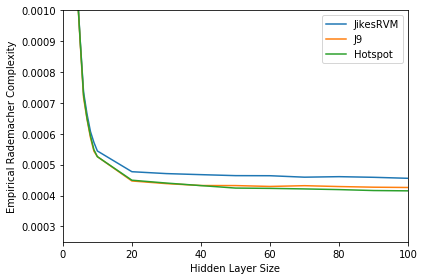

In [388]:
plt.plot(hidden_sizes, rademacher_jikes_mod_list, label="JikesRVM")
plt.plot(hidden_sizes, rademacher_j9_mod_list, label="J9")
plt.plot(hidden_sizes, rademacher_hotspot_mod_list, label="Hotspot")
plt.legend()
# plt.ylim((0.0002, 0.0005))
plt.ylim((0.00025, 0.001))
plt.xlim((0, 100))
plt.xlabel("Hidden Layer Size")
plt.ylabel("Empirical Rademacher Complexity")
plt.tight_layout()
# plt.show()
plt.savefig("output_files/plots/{}_100.jpg".format(trace_name), dpi=500)

print("jikes_min: ", np.min(rademacher_jikes_mod_list))
print("j9 min: ", np.min(rademacher_j9_mod_list))
print("hotspot min: ", np.min(rademacher_hotspot_mod_list))

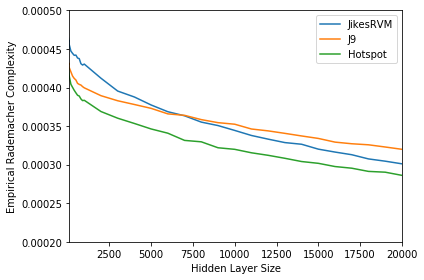

In [389]:
plt.plot(hidden_sizes, rademacher_jikes_mod_list, label="JikesRVM")
plt.plot(hidden_sizes, rademacher_j9_mod_list, label="J9")
plt.plot(hidden_sizes, rademacher_hotspot_mod_list, label="Hotspot")
plt.legend()
# plt.ylim((0.0001, 0.0002))
# plt.ylim((0.0001, 0.0004))
plt.ylim((0.0002, 0.0005))
plt.xlim((100, 20000))
plt.xlabel("Hidden Layer Size")
plt.ylabel("Empirical Rademacher Complexity")
plt.tight_layout()
# plt.show()
plt.savefig("output_files/plots/{}_8000.jpg".format(trace_name), dpi=500)
plt.show()

In [390]:
# start_point = 10000
# n_points = 5000
# history_size = 40

# seeds = range(30)

# trace = pd.read_pickle(
#     '../data/{}-small-JikesRVM-d-l64-p4096-w100000i.analyzed-1.pkl'.format(trace_name)
# ).to_numpy()[start_point:start_point+n_points]

# accuracy_list = []

# for hidden in hidden_sizes:
#     acc = []
#     for seed in seeds:
#         predictions = np.load(
#             'output_files/{}/jikes/predictions_{}_{}_{}_{}.npy'.format(trace_name, 40, seed, hidden, 1))
#         predictions = np.argsort(predictions)

#         top_k = 5
#         count = 0
#         for idx, point in enumerate(trace):
# #             print("{}: {}, {}".format(idx, np.argmax(point), predictions[idx, -(top_k):]))
#             if float(np.argmax(point)) in predictions[idx+39, -top_k:]:
#                 count += 1
# #         print("count: {}".format(count))
# #         print("{}, {} : {}".format(history, seed, count/trace.shape[0]))
#         acc.append(count/trace.shape[0])
#     accuracy_list.append(np.mean(acc))
#         #     print("{}: {}, {}".format(idx, np.argmax(point), predictions[idx, -1]))

In [391]:
# plt.plot(hidden_sizes, accuracy_list)
# plt.show()

In [11]:
actual = []
predicted = []

predictions = np.load(
            'output_files/{}/jikes/predictions_{}_{}_{}_{}.npy'.format(trace_name, 40, 1, 1, 1))
predictions = np.argsort(predictions)

for idx, point in enumerate(trace):
    actual.append(float(np.argmax(point)))
    predicted.append(predictions[idx, -1])

In [393]:
print(predicted[:100])

[99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23]


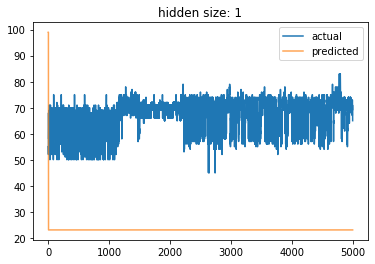

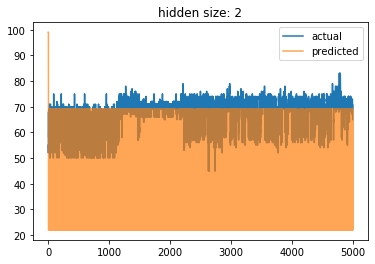

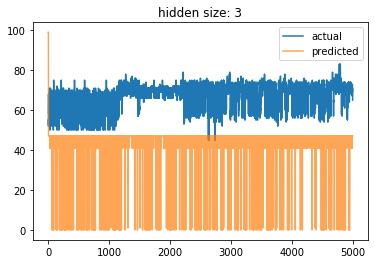

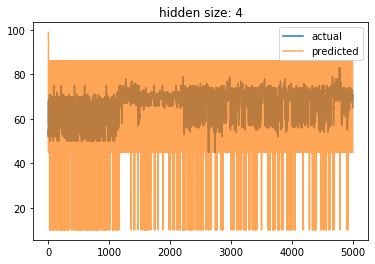

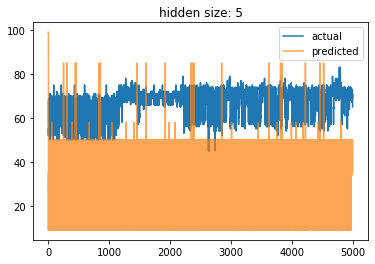

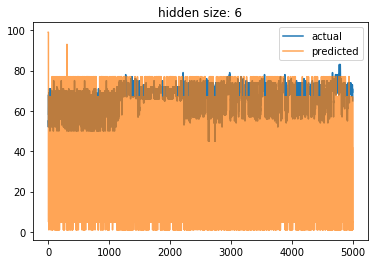

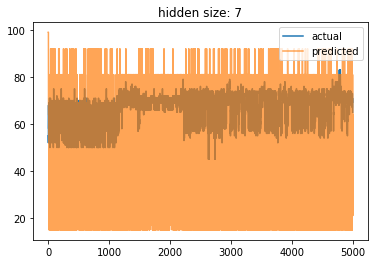

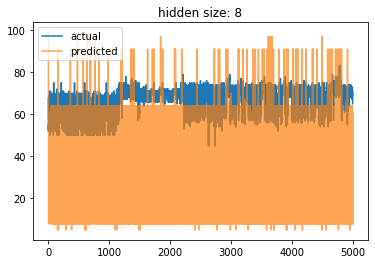

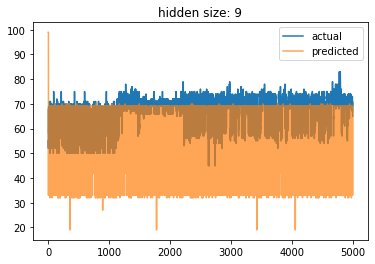

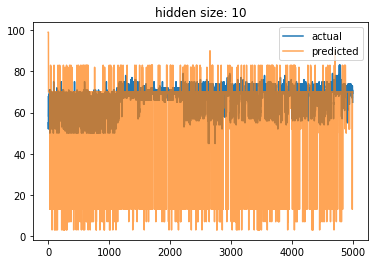

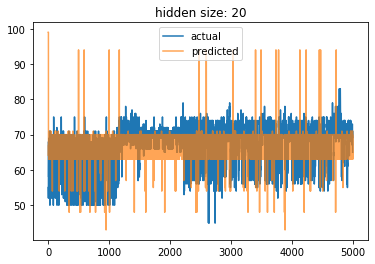

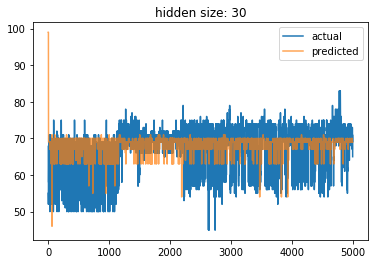

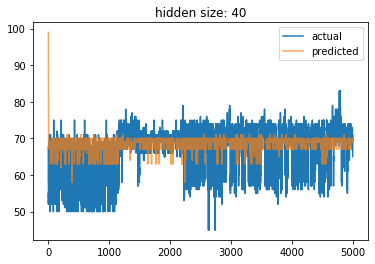

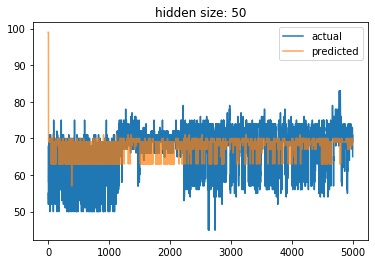

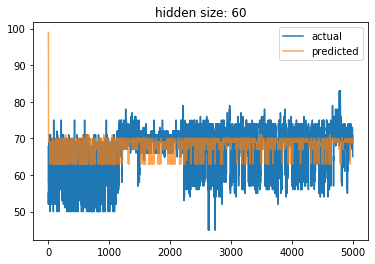

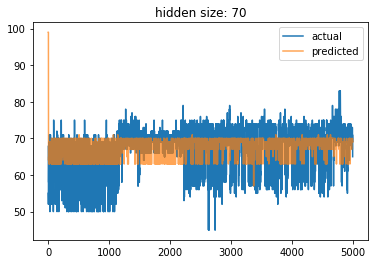

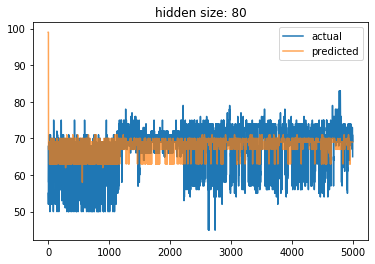

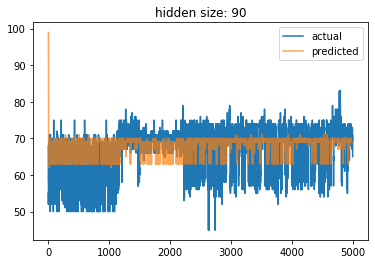

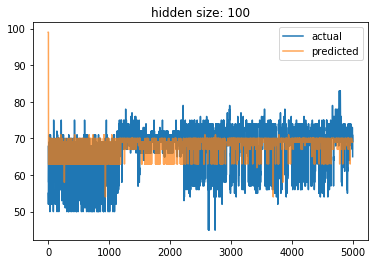

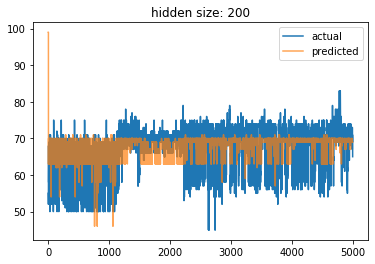

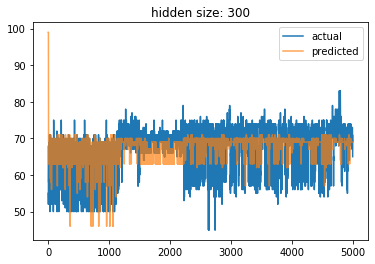

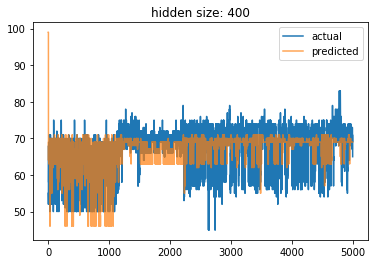

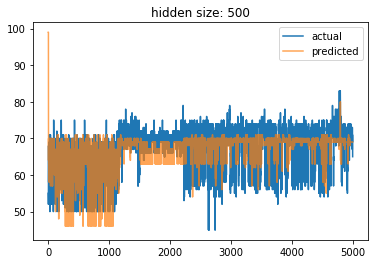

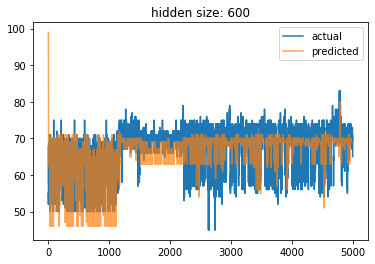

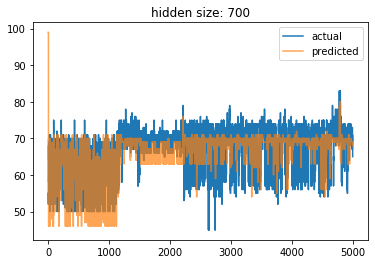

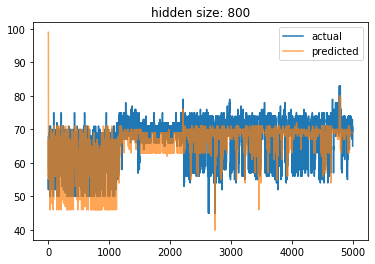

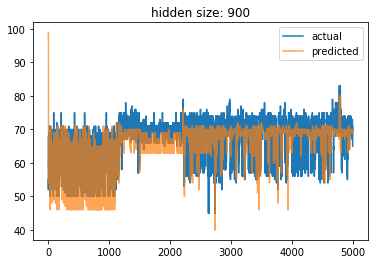

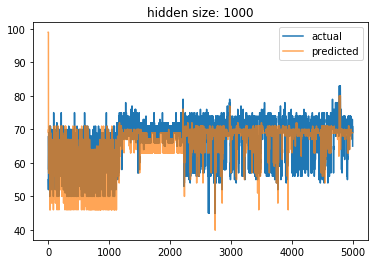

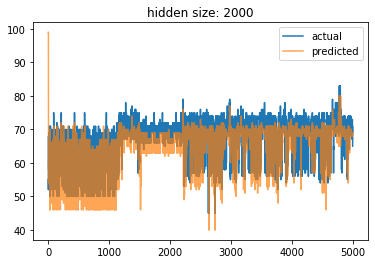

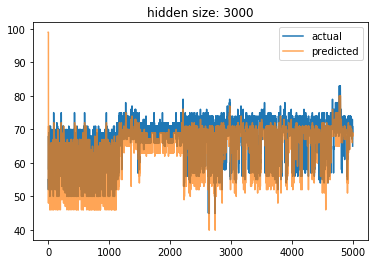

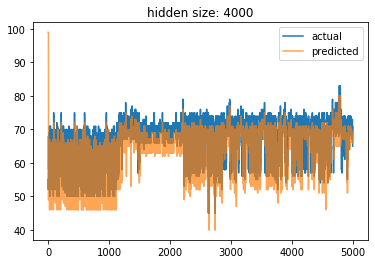

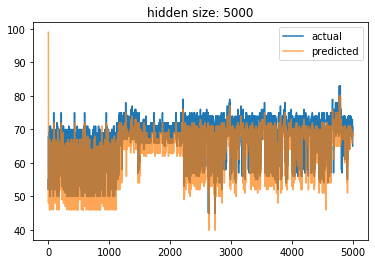

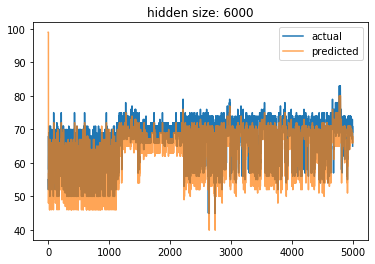

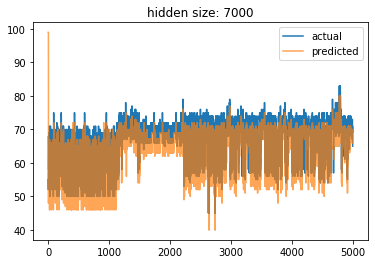

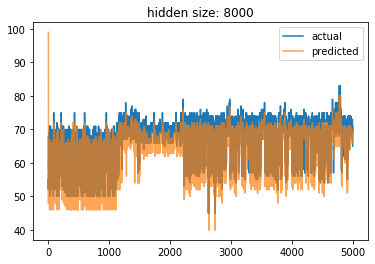

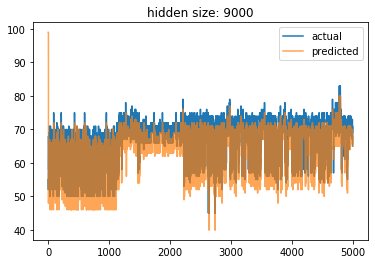

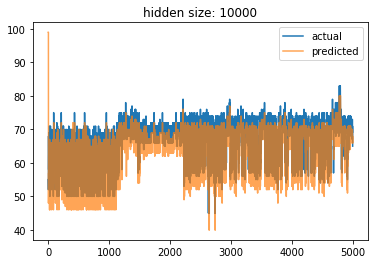

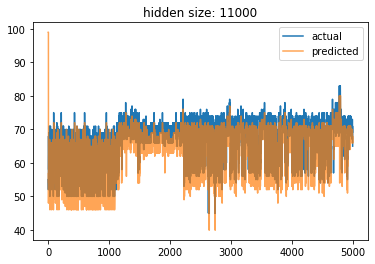

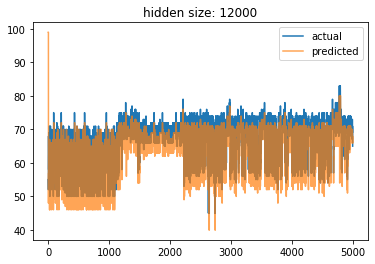

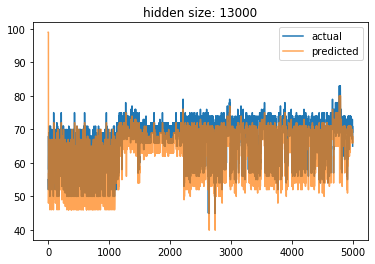

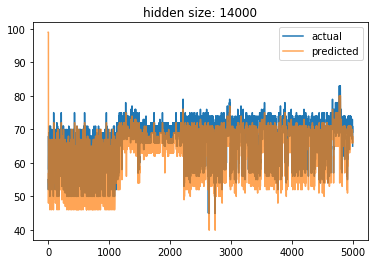

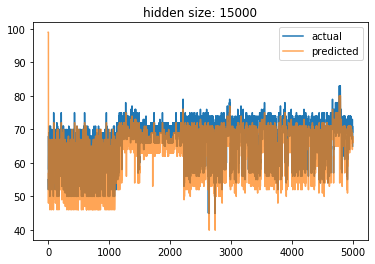

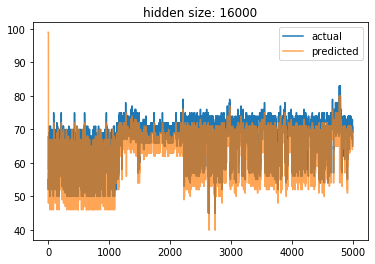

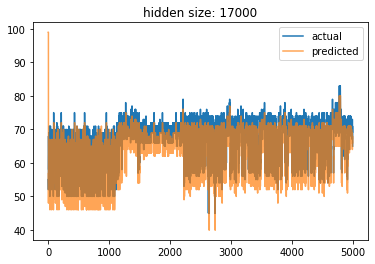

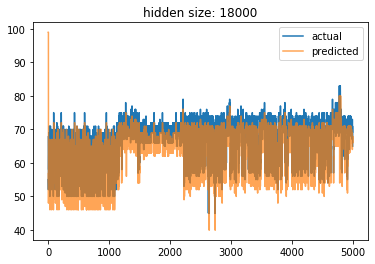

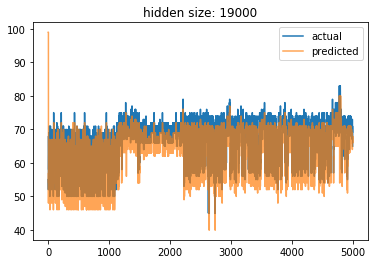

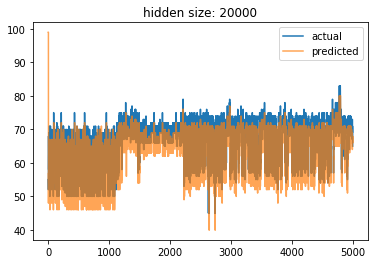

In [9]:
trace = plot_actual_predicted(trace_name, "jikes")

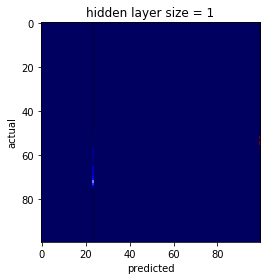

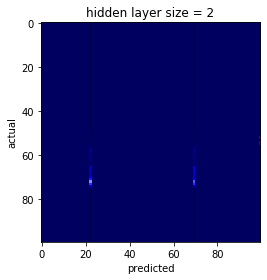

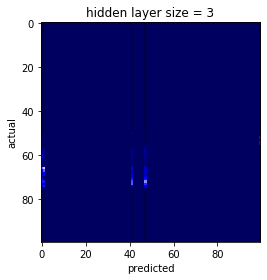

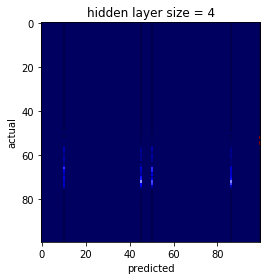

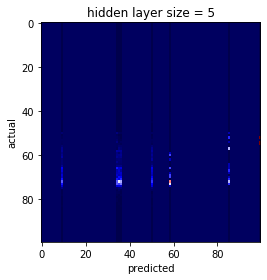

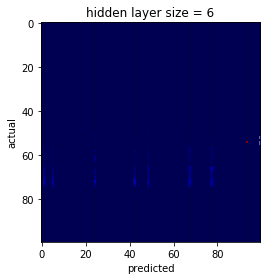

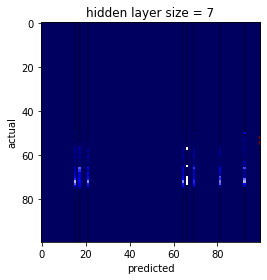

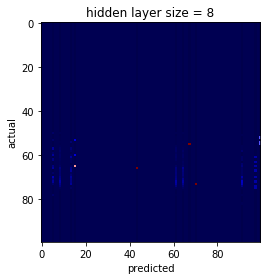

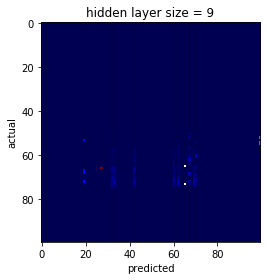

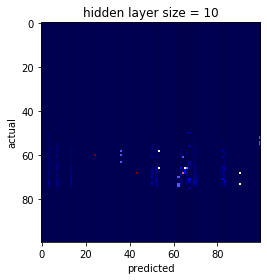

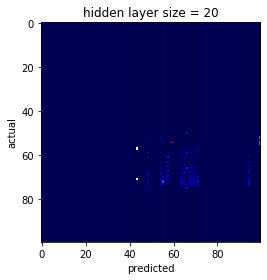

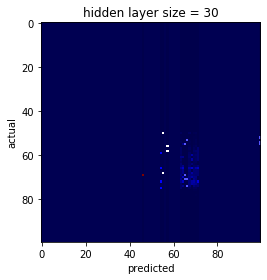

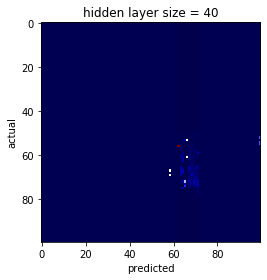

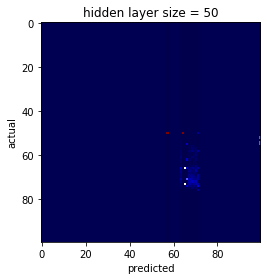

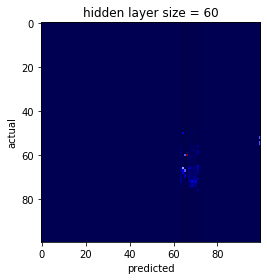

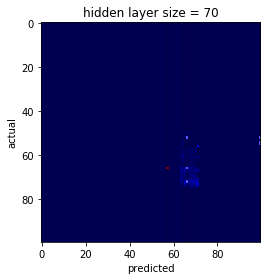

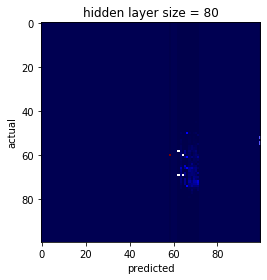

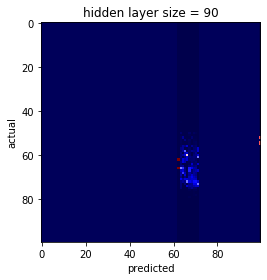

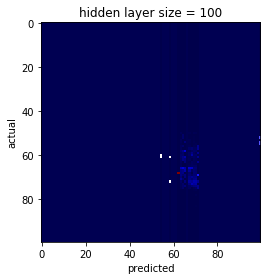

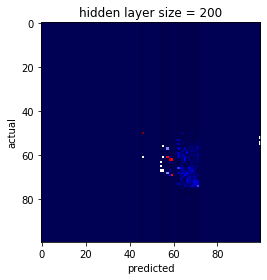

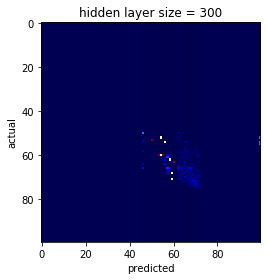

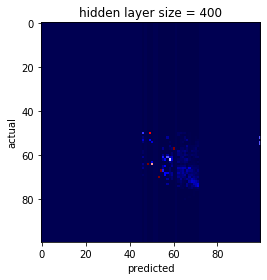

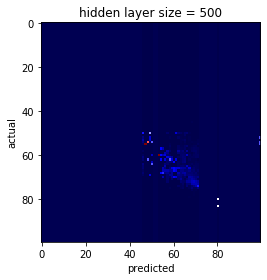

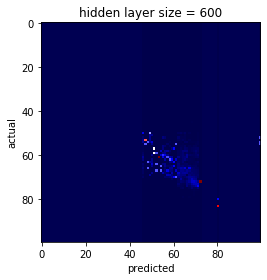

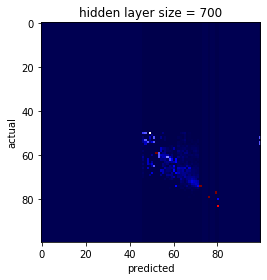

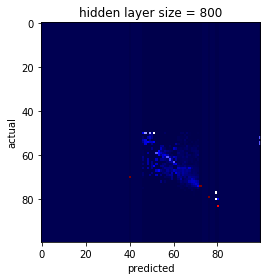

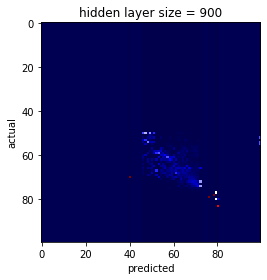

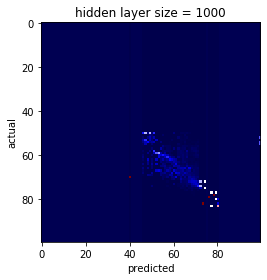

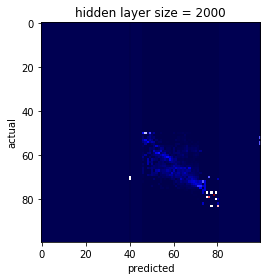

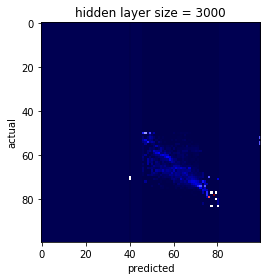

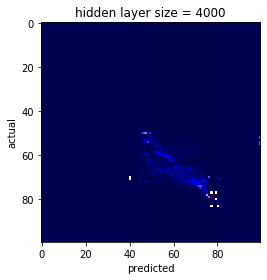

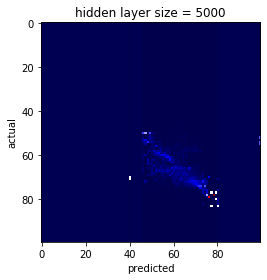

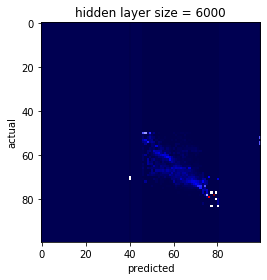

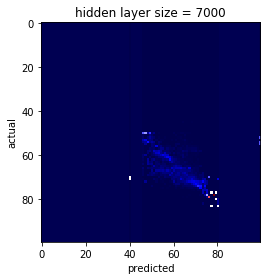

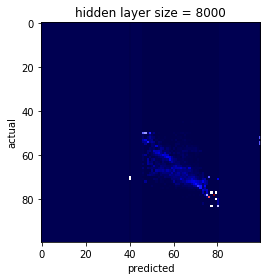

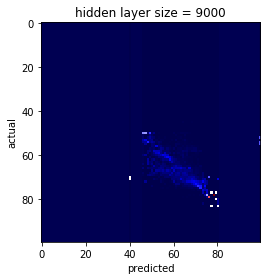

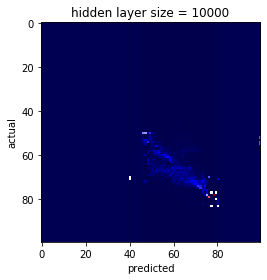

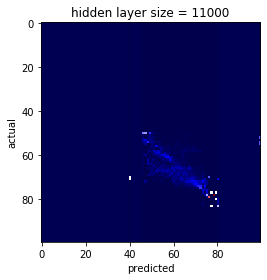

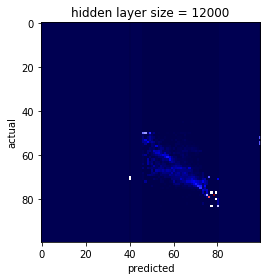

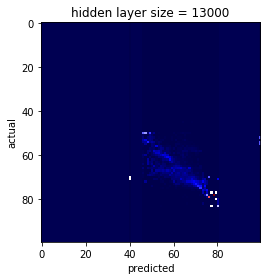

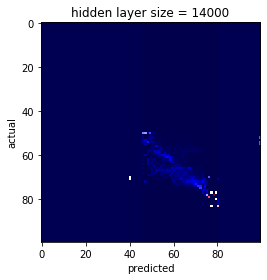

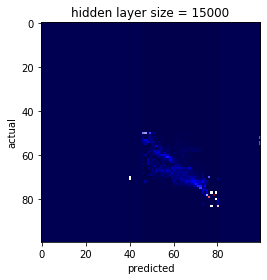

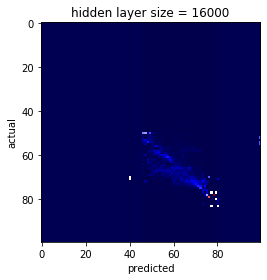

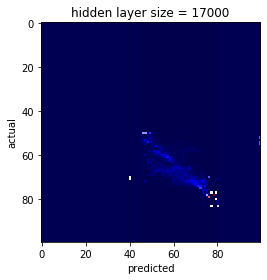

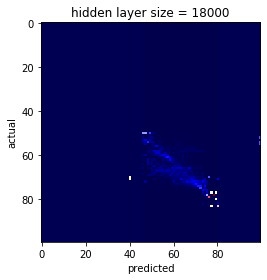

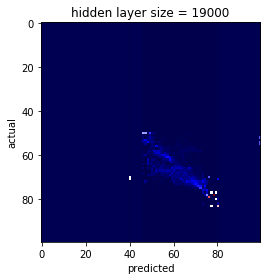

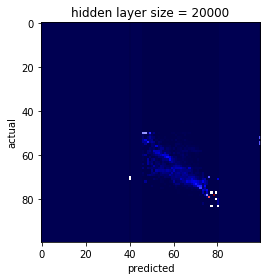

In [13]:
history_size=40
prediction_map = get_heatmaps(trace_name, trace, predictions, jvm="jikes")

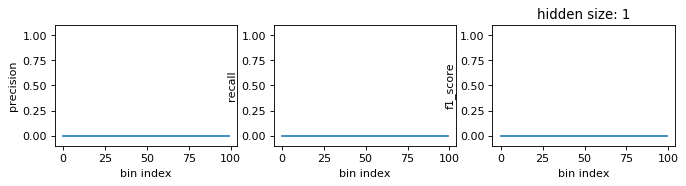

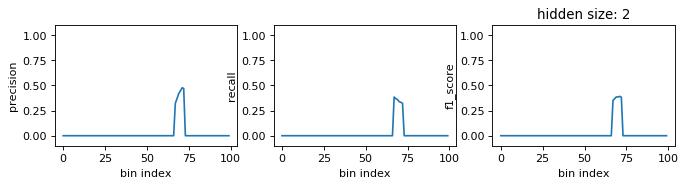

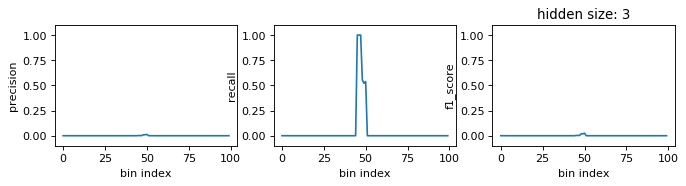

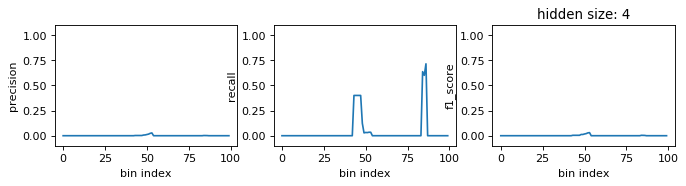

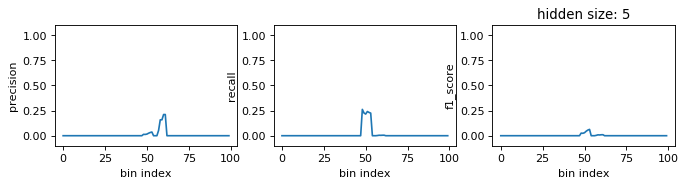

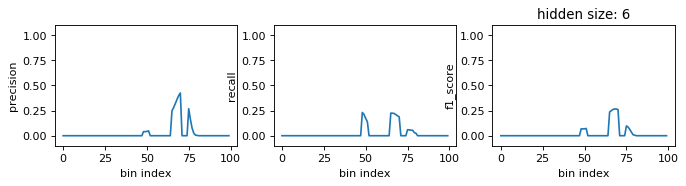

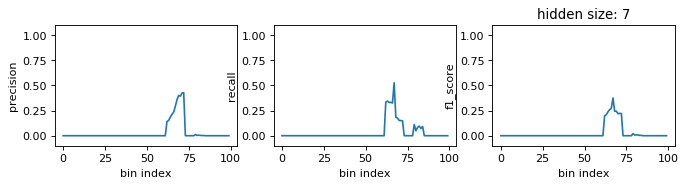

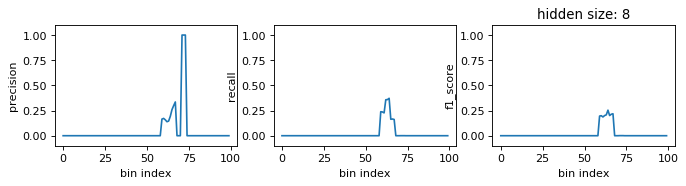

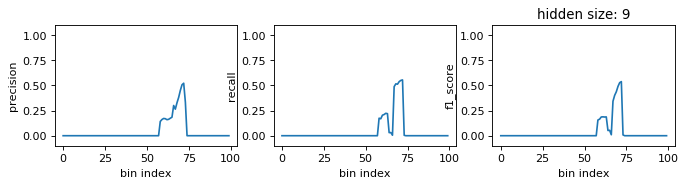

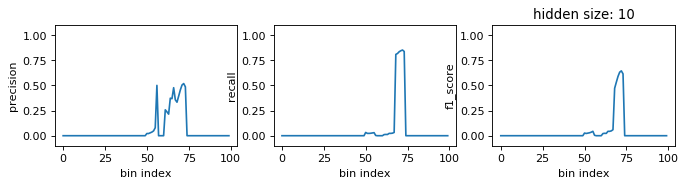

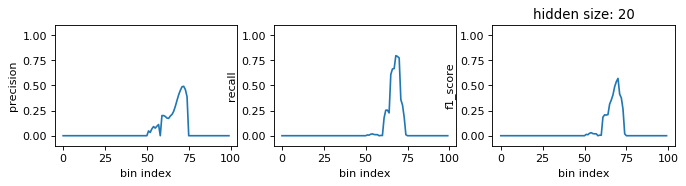

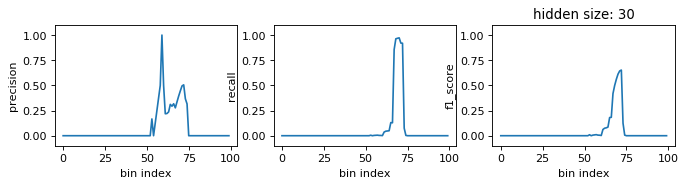

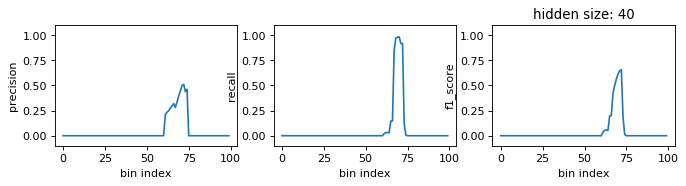

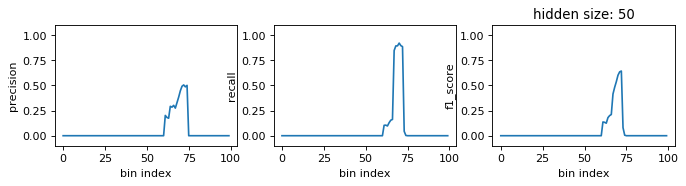

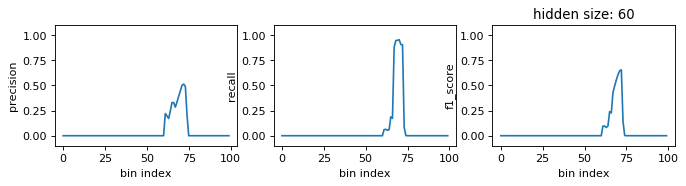

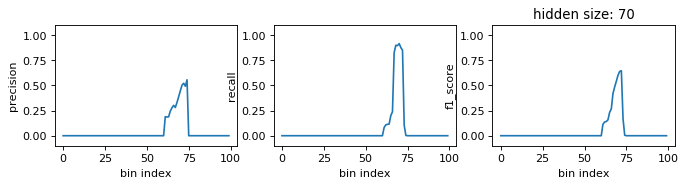

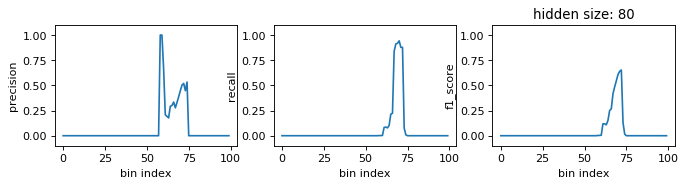

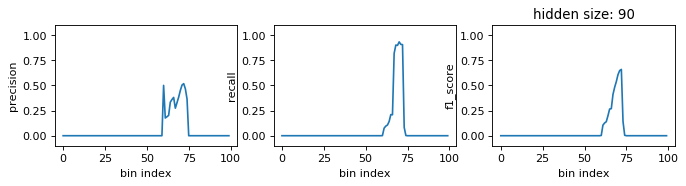

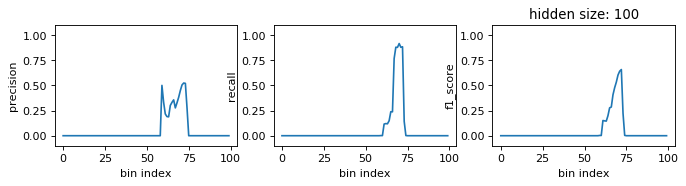

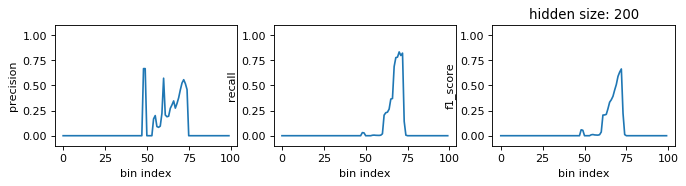

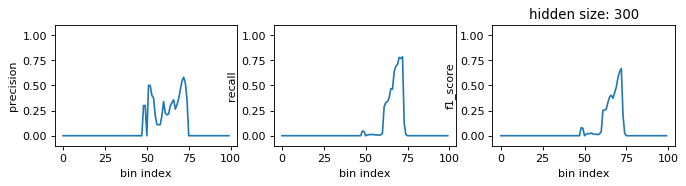

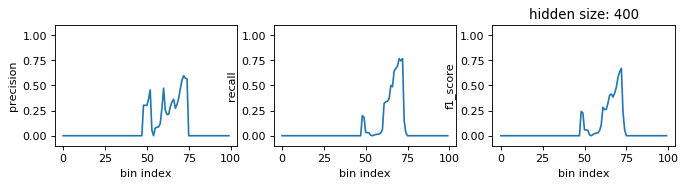

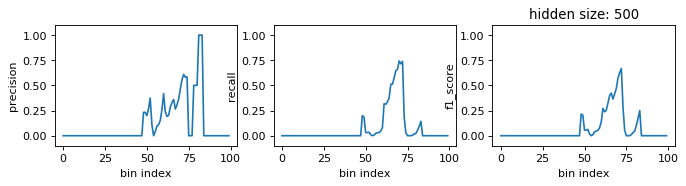

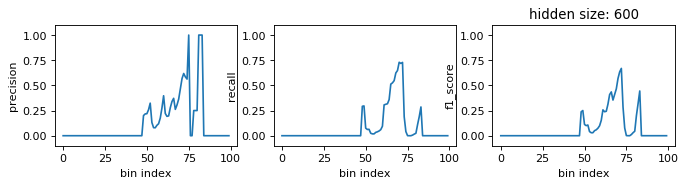

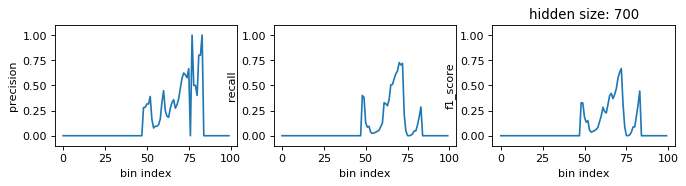

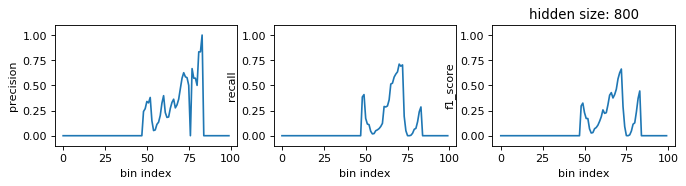

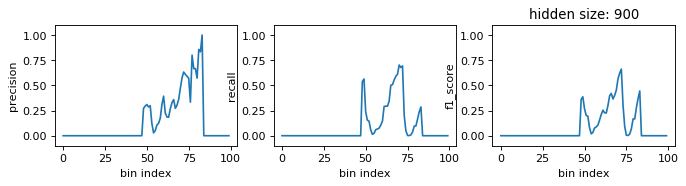

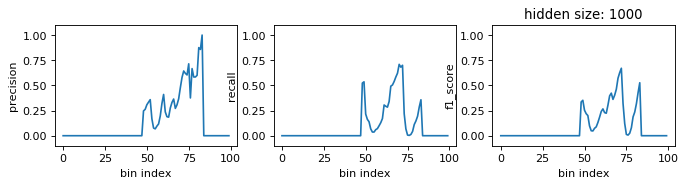

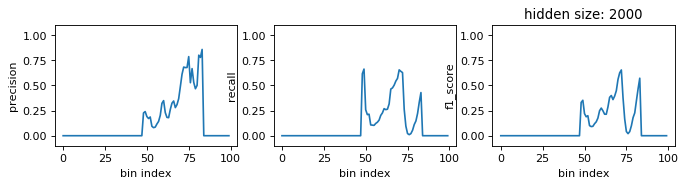

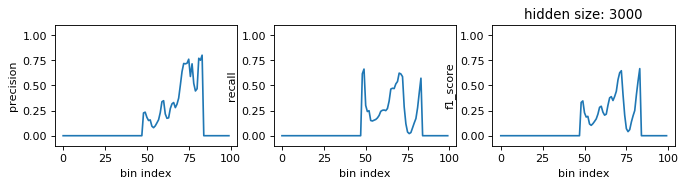

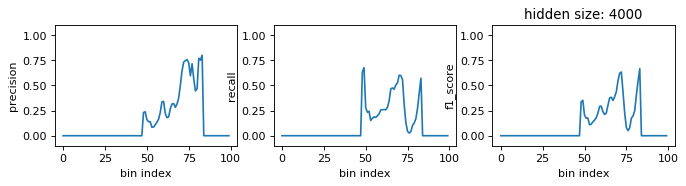

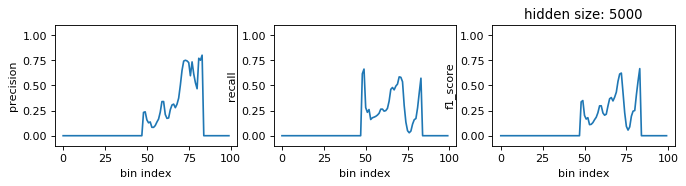

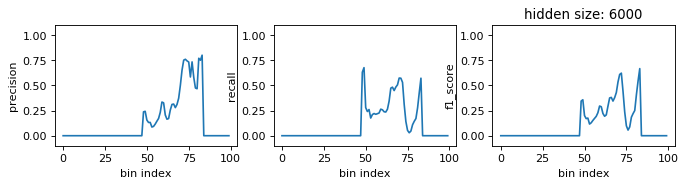

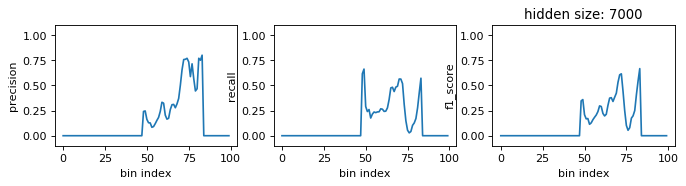

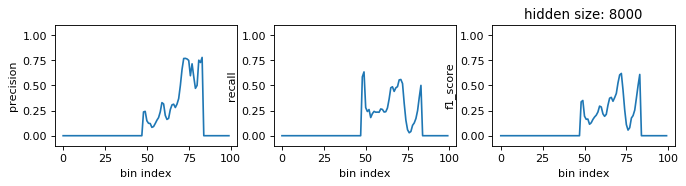

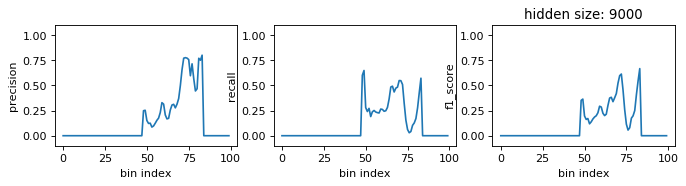

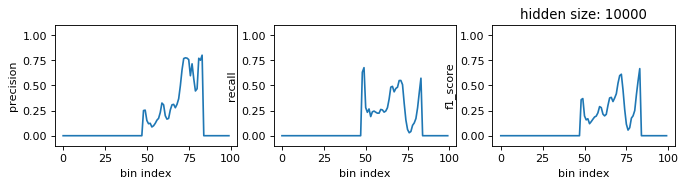

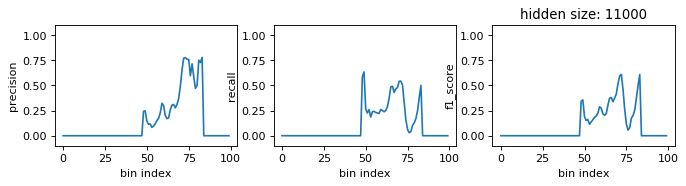

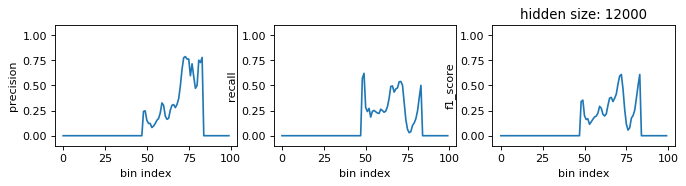

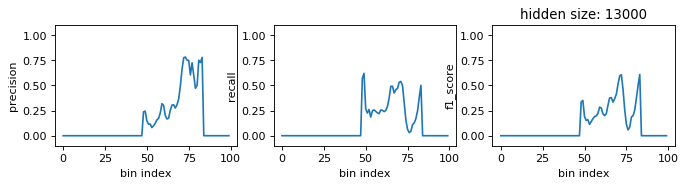

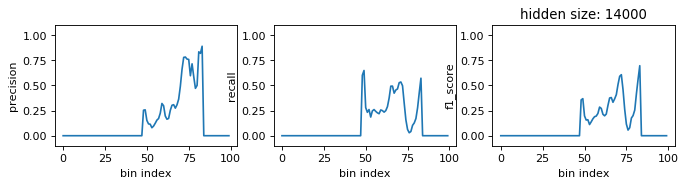

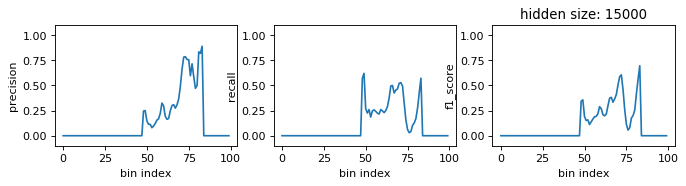

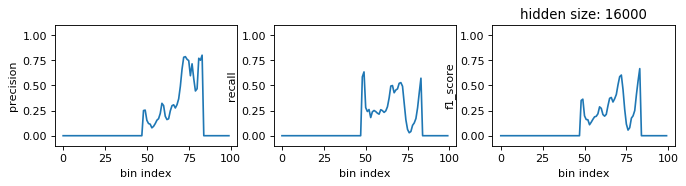

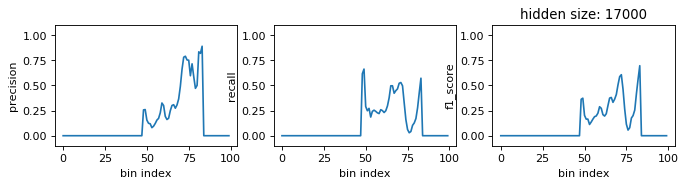

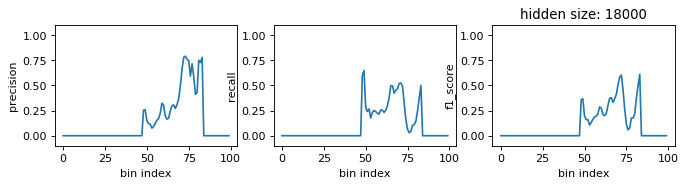

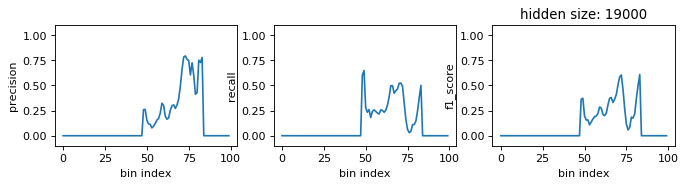

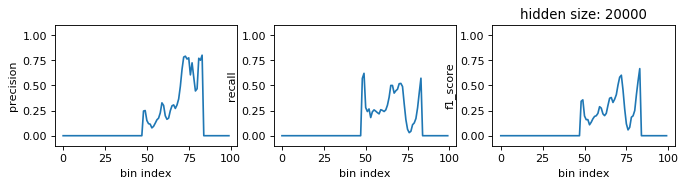

In [14]:
avg_precision_list, avg_recall_list, avg_f1_list = compute_prec_recall_curves(prediction_map)

In [397]:
print(hidden_sizes)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000, 11000, 12000, 13000, 14000, 15000, 16000, 17000, 18000, 19000, 20000]


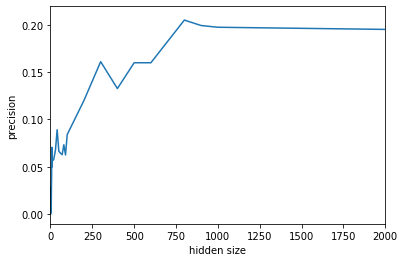

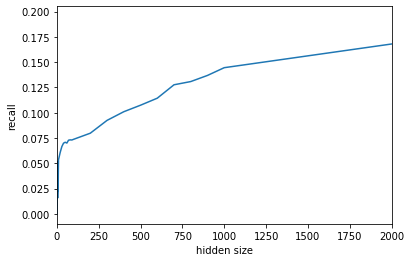

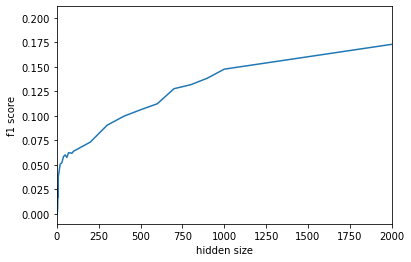

In [398]:
plt.plot(hidden_sizes, avg_precision_list)
plt.xlabel("hidden size")
plt.ylabel("precision")
plt.xlim((0, 2000))
plt.show()

plt.plot(hidden_sizes, avg_recall_list)
plt.xlabel("hidden size")
plt.ylabel("recall")
plt.xlim((0, 2000))
plt.show()

plt.plot(hidden_sizes, avg_f1_list)
plt.xlabel("hidden size")
plt.ylabel("f1 score")
plt.xlim((0, 2000))
plt.show()

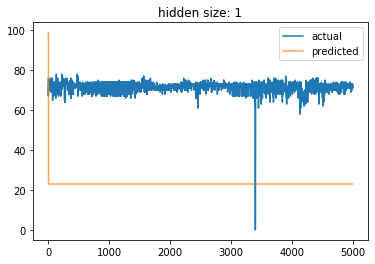

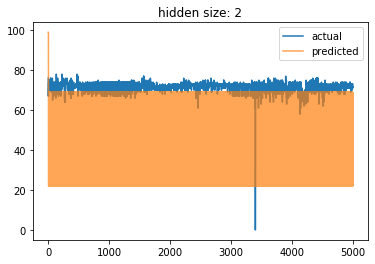

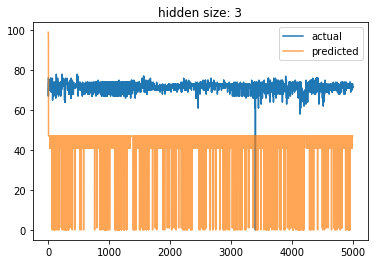

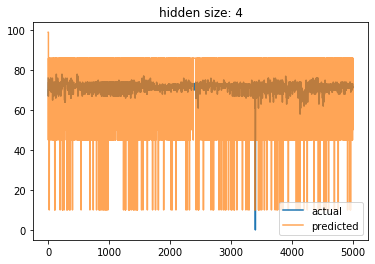

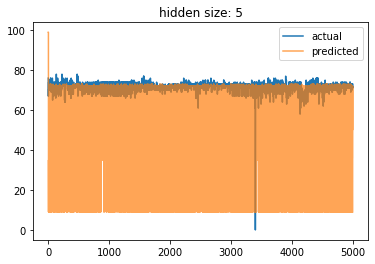

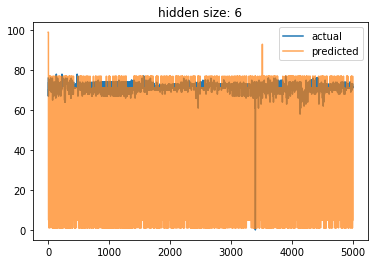

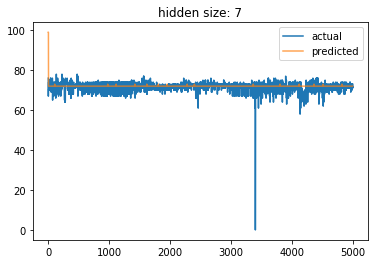

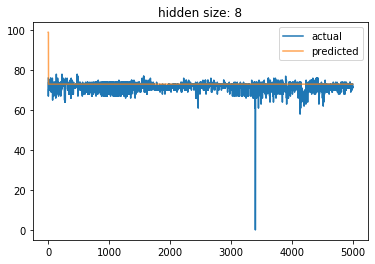

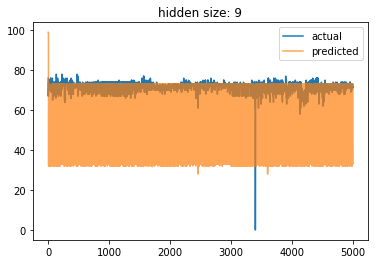

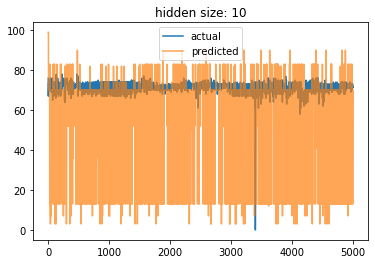

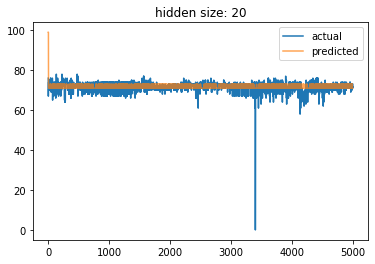

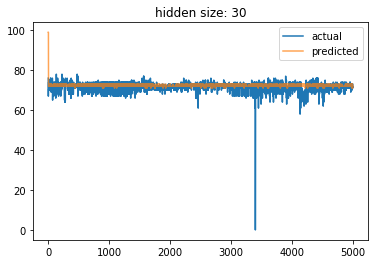

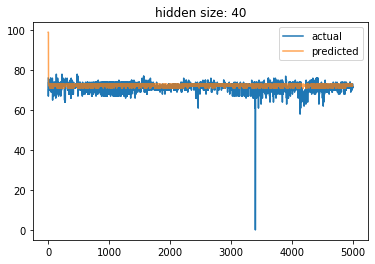

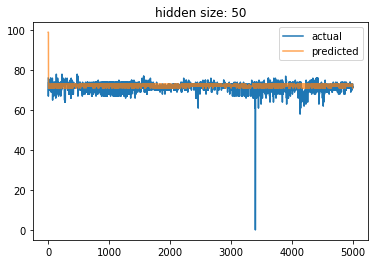

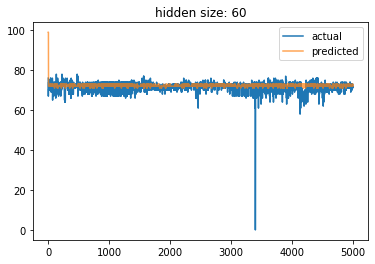

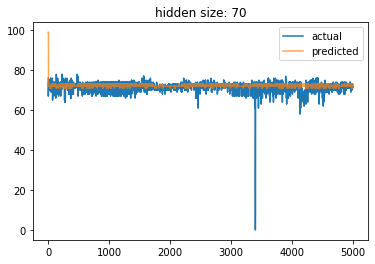

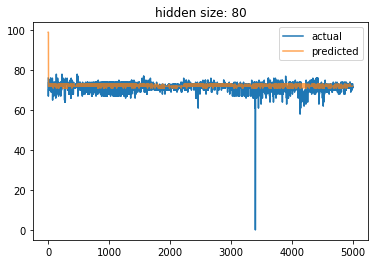

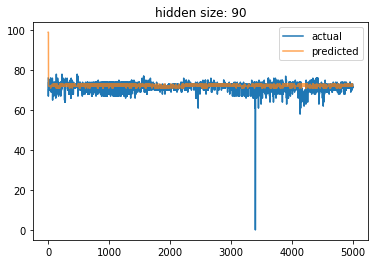

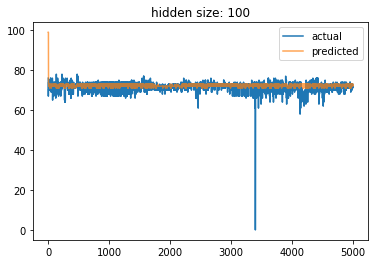

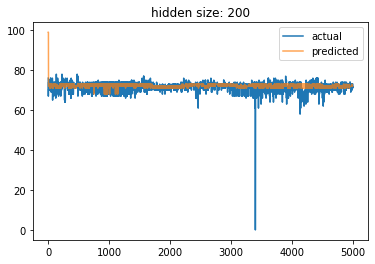

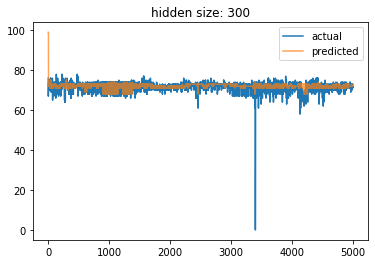

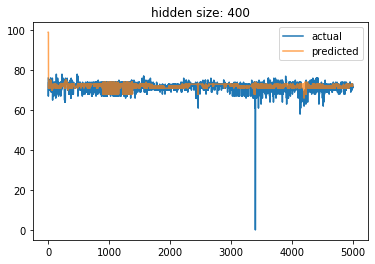

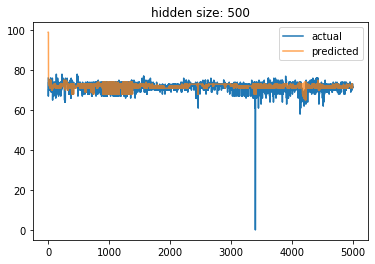

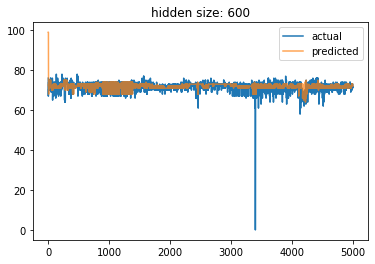

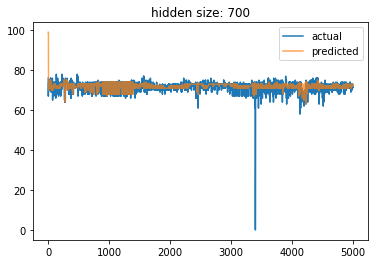

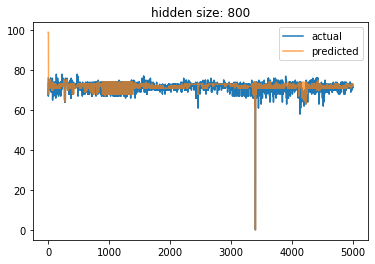

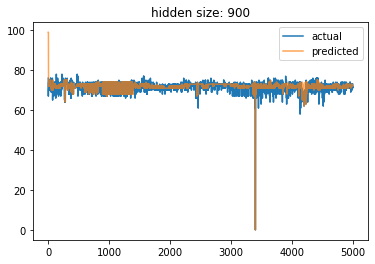

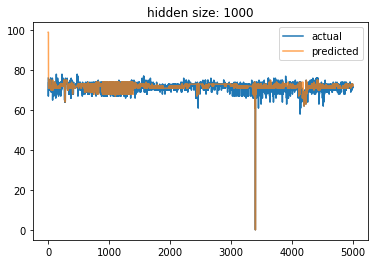

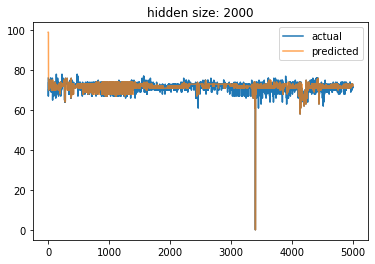

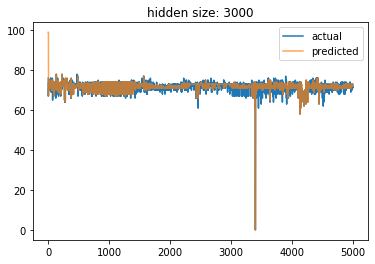

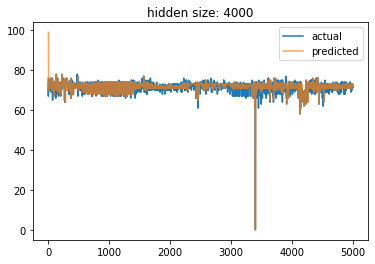

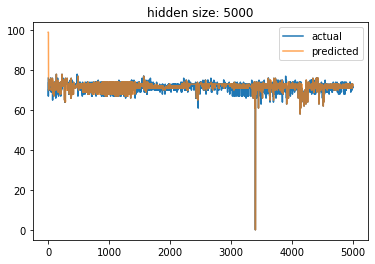

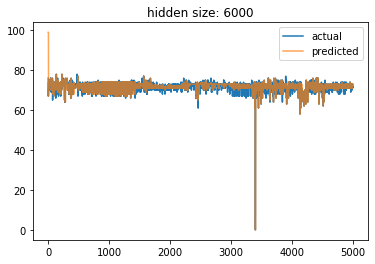

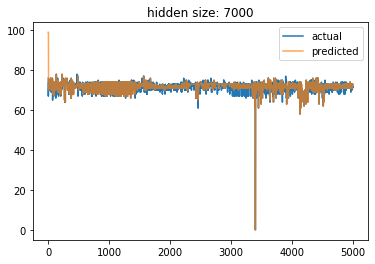

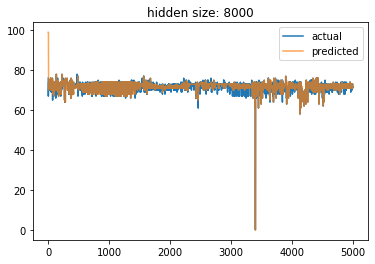

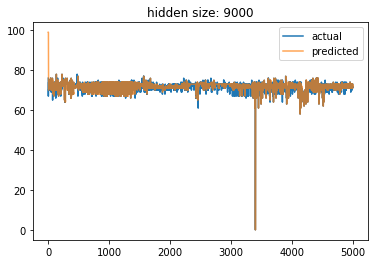

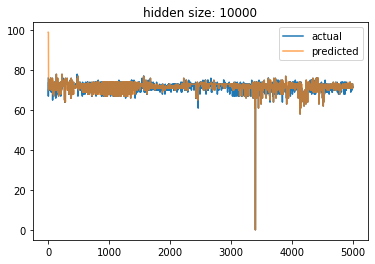

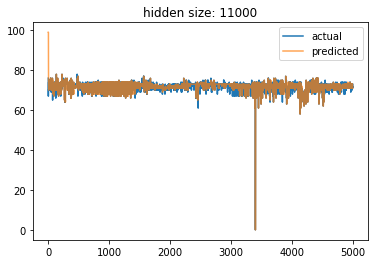

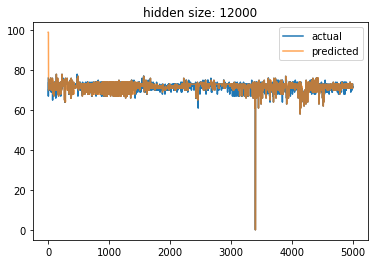

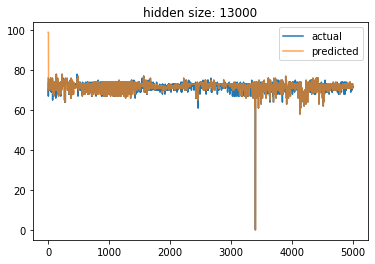

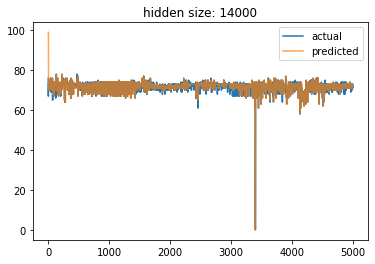

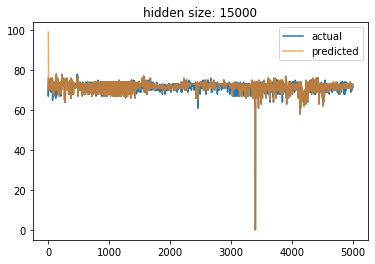

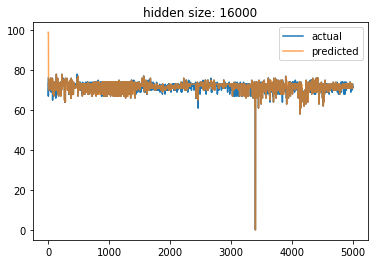

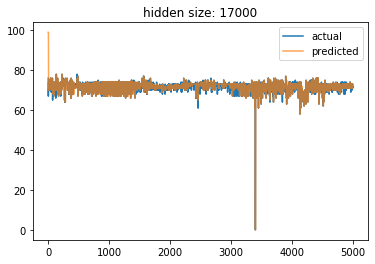

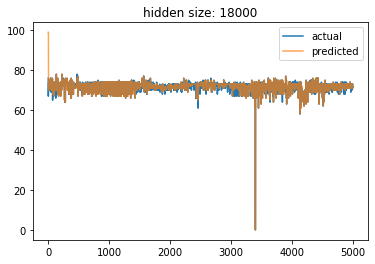

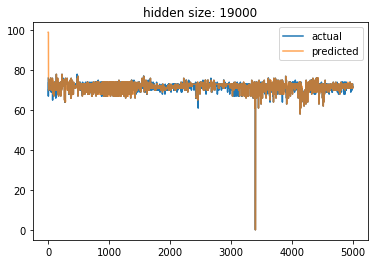

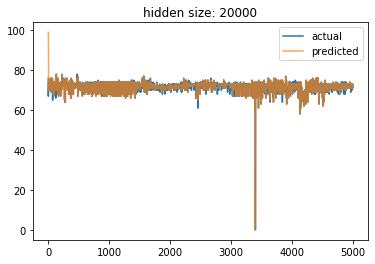

In [399]:
trace = plot_actual_predicted(trace_name, "j9")

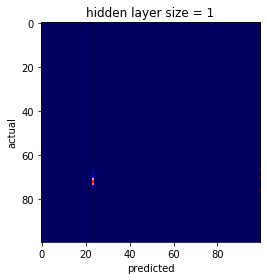

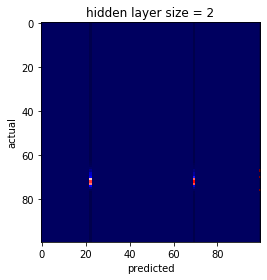

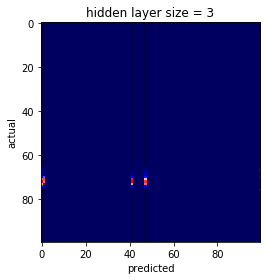

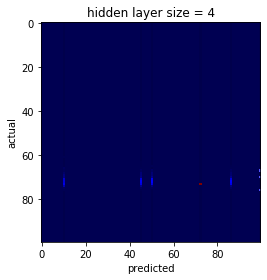

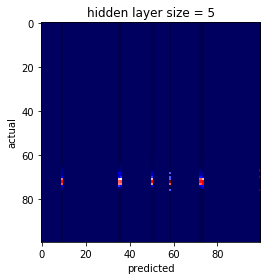

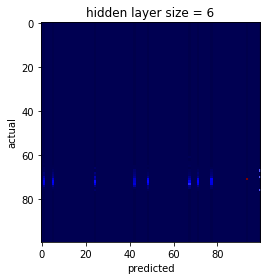

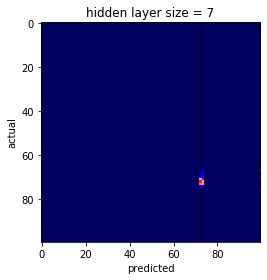

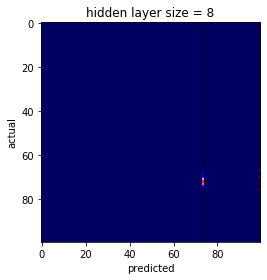

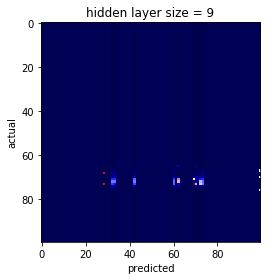

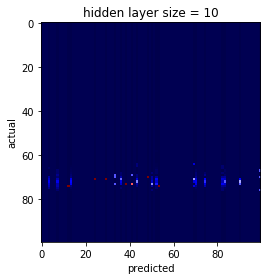

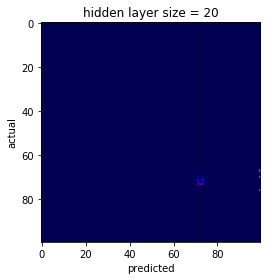

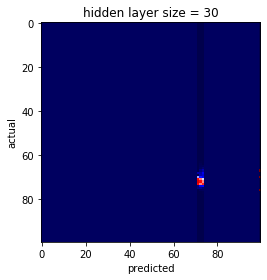

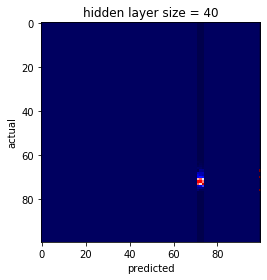

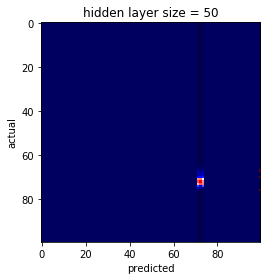

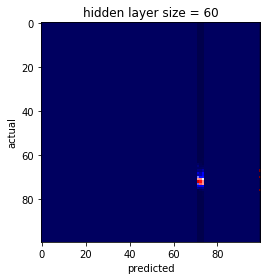

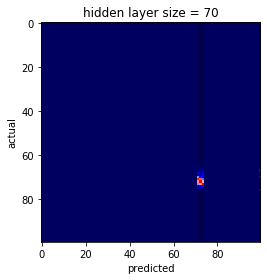

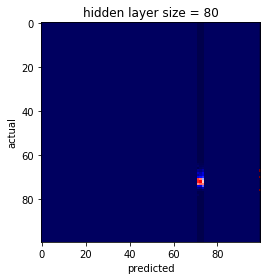

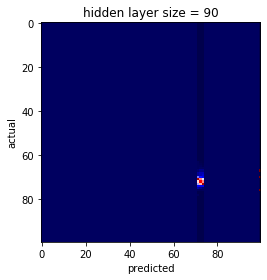

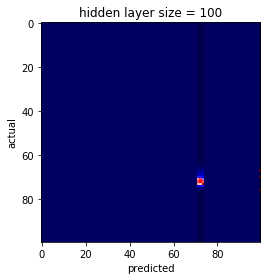

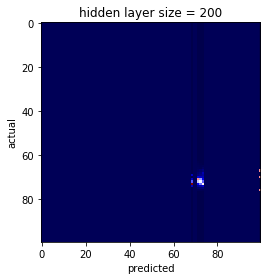

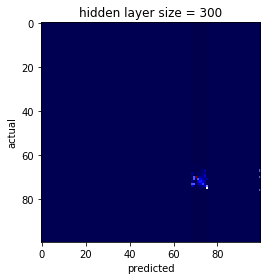

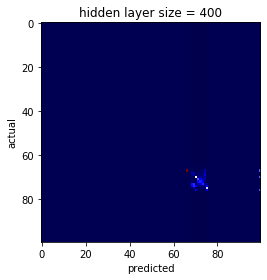

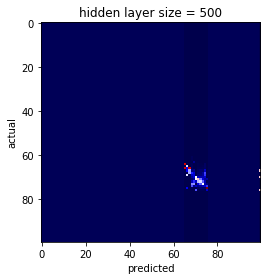

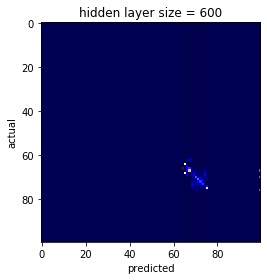

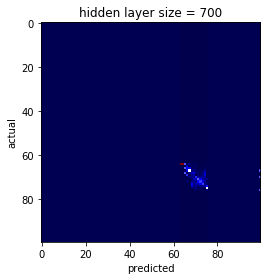

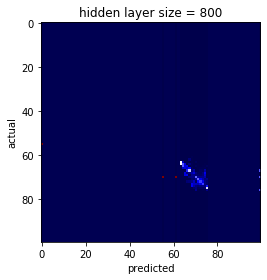

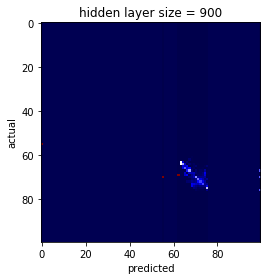

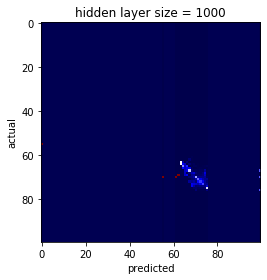

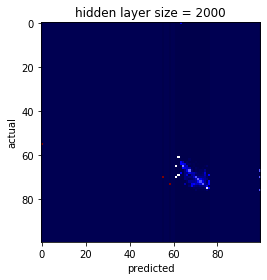

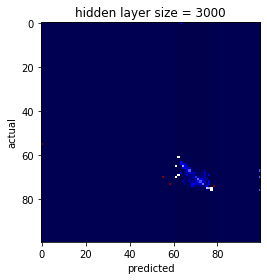

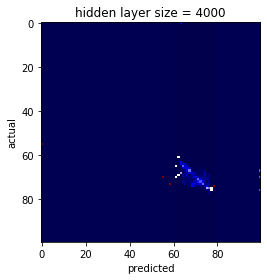

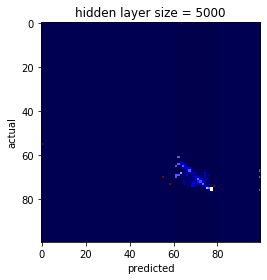

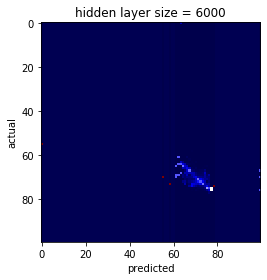

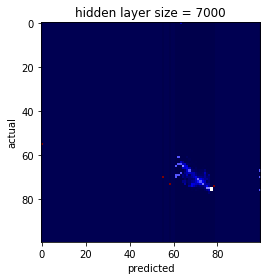

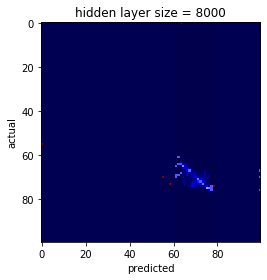

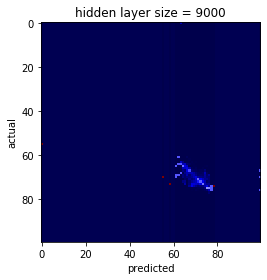

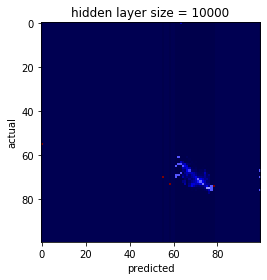

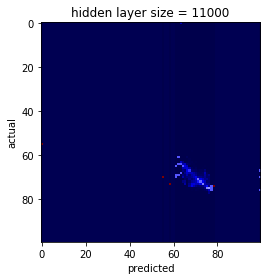

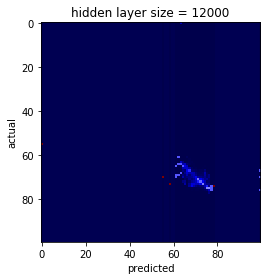

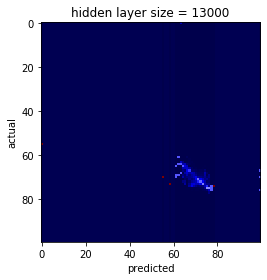

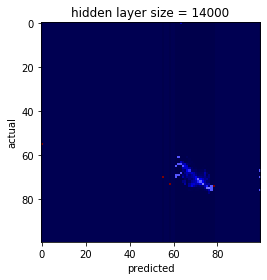

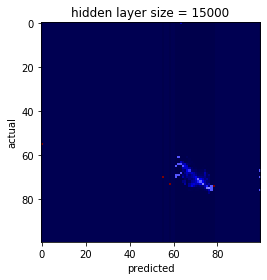

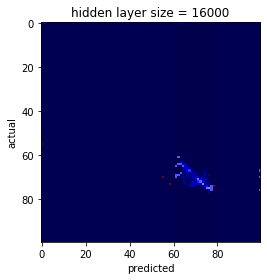

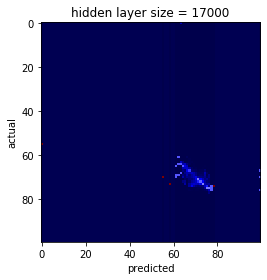

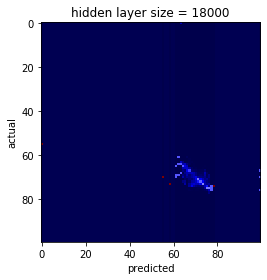

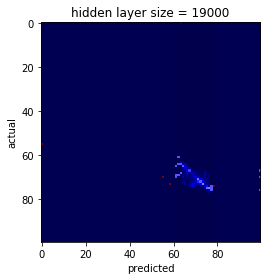

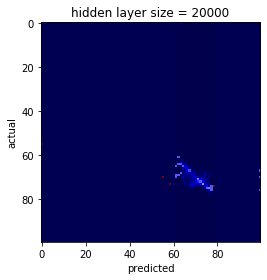

In [400]:
prediction_map = get_heatmaps(trace_name, trace, predictions, jvm="j9")

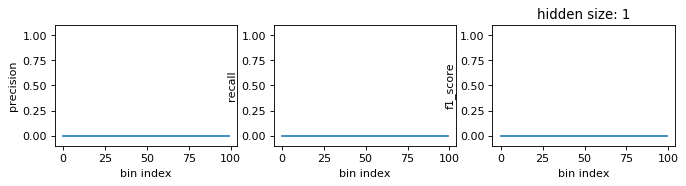

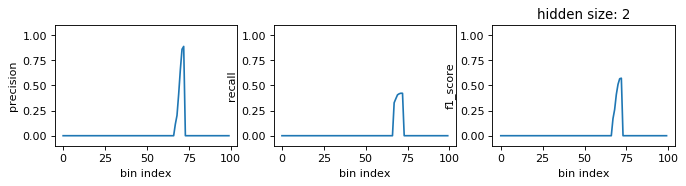

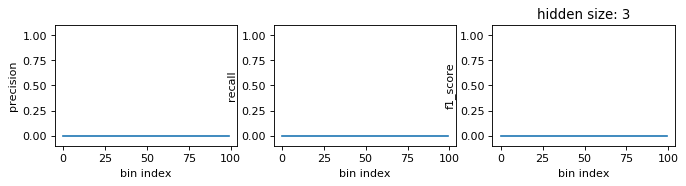

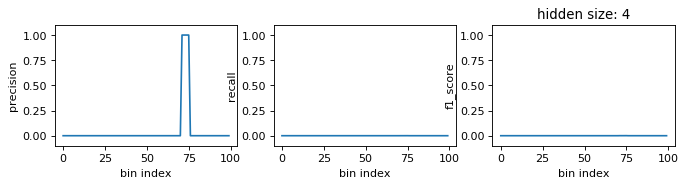

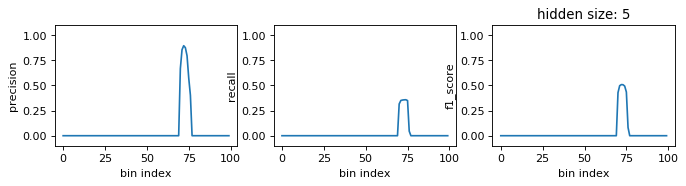

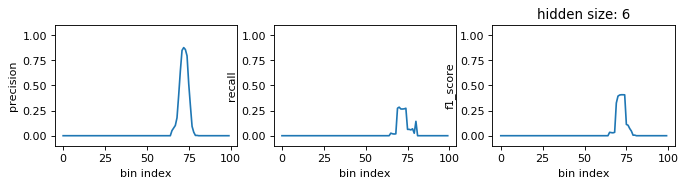

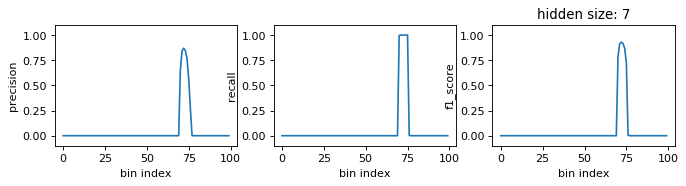

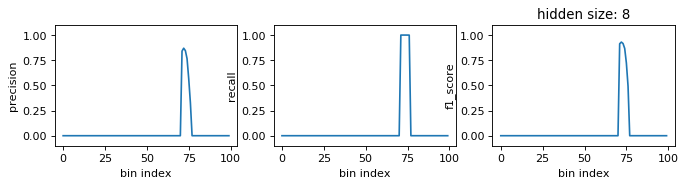

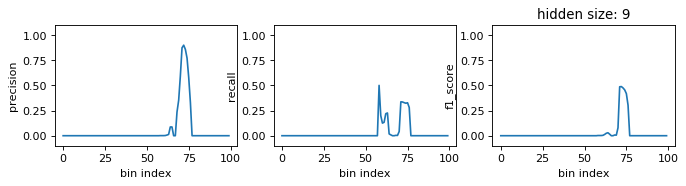

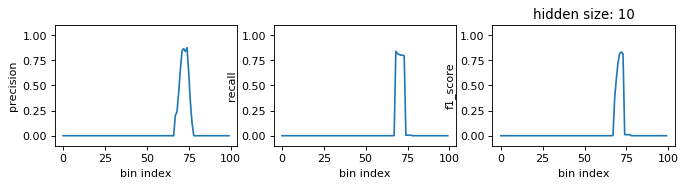

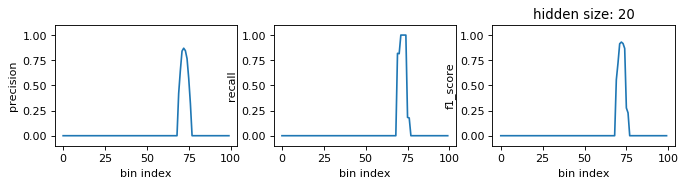

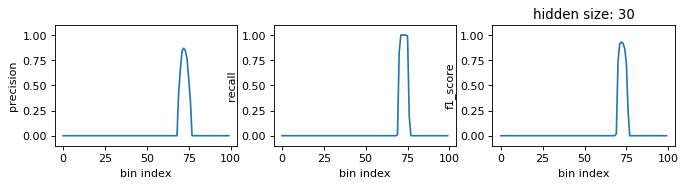

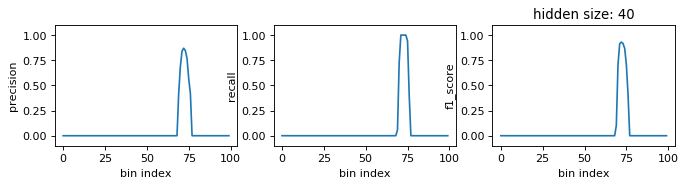

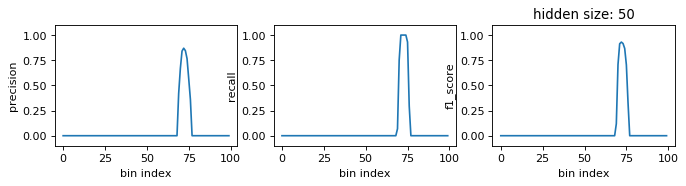

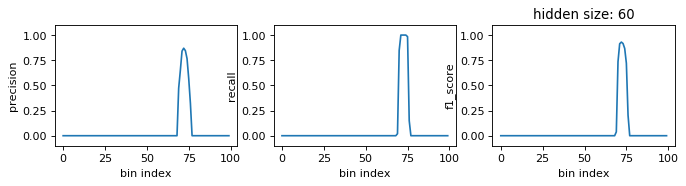

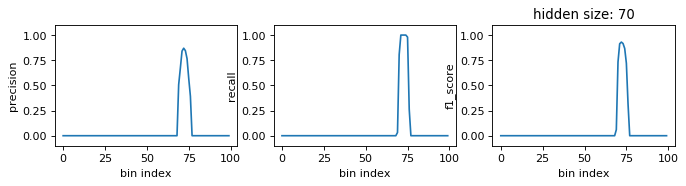

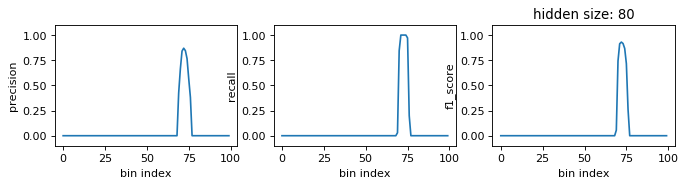

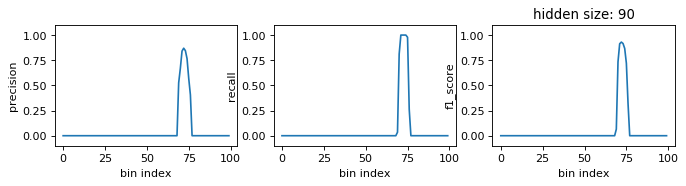

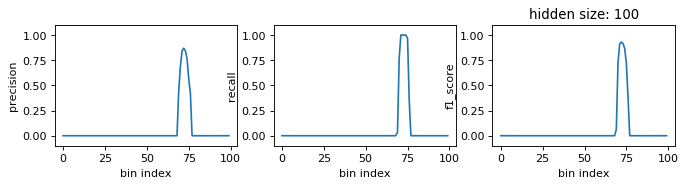

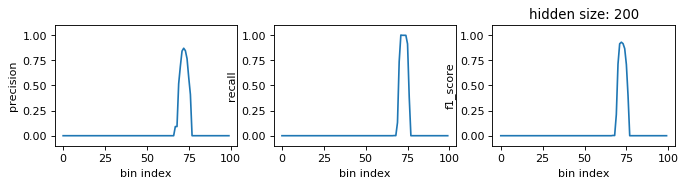

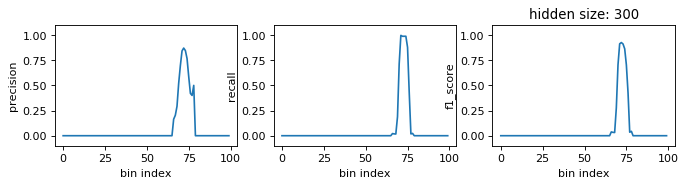

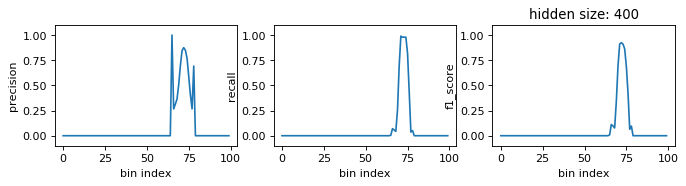

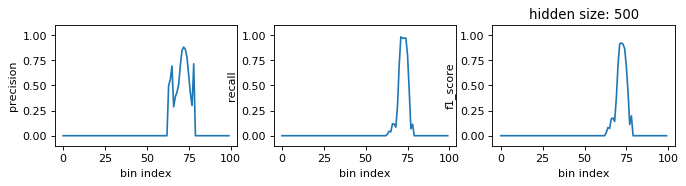

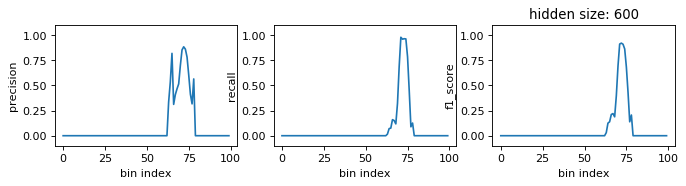

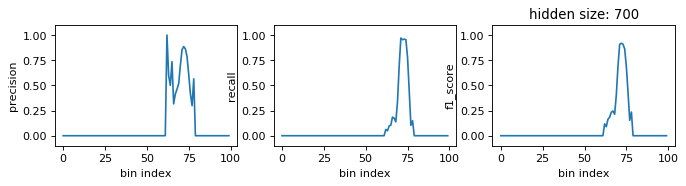

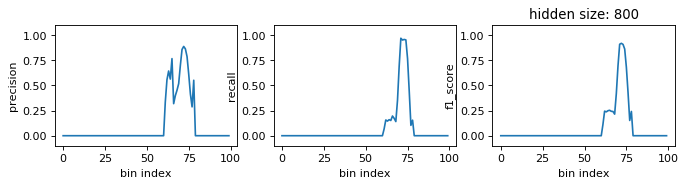

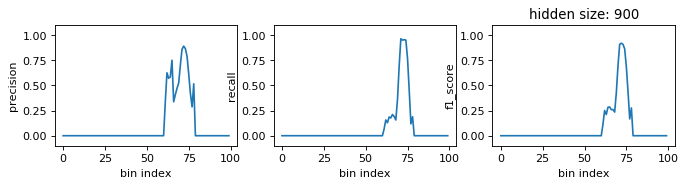

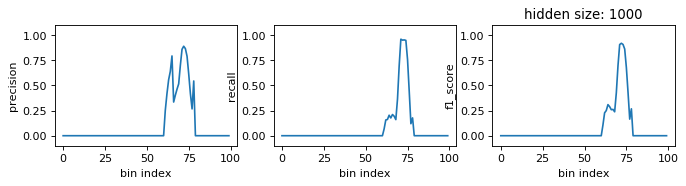

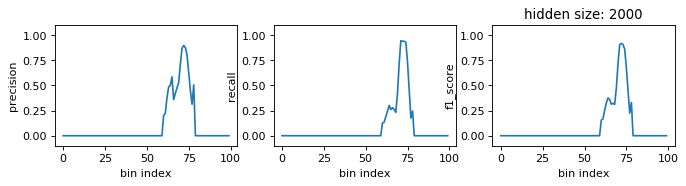

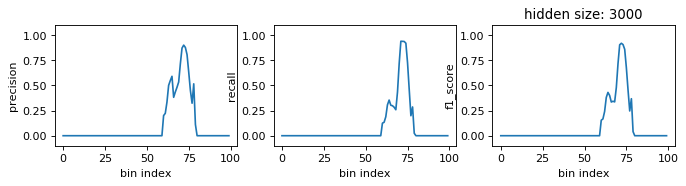

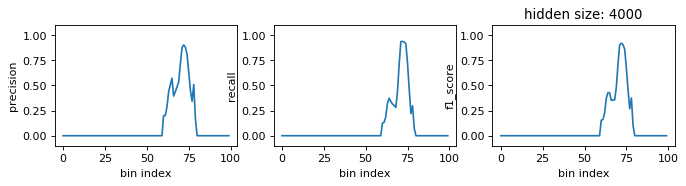

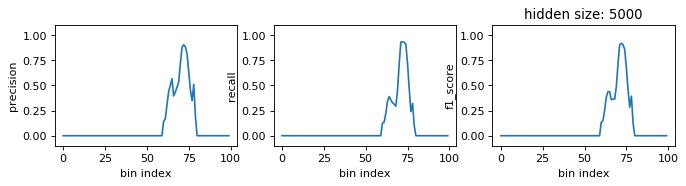

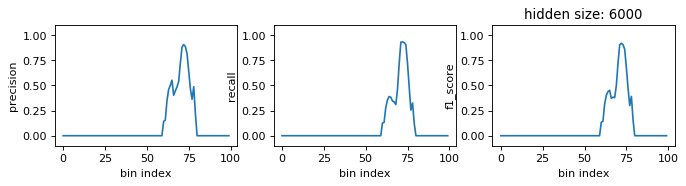

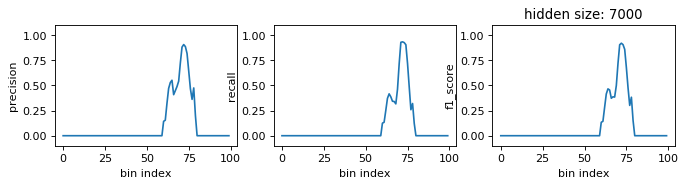

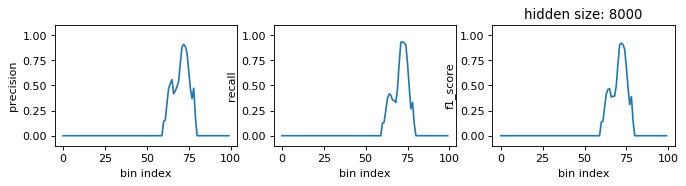

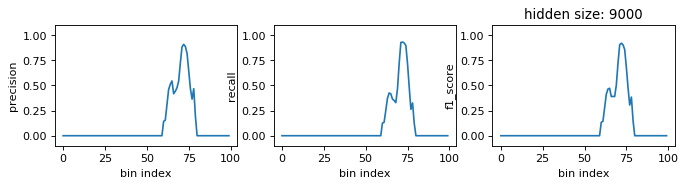

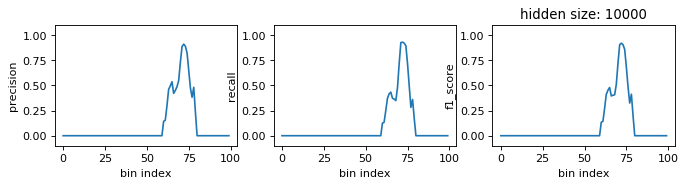

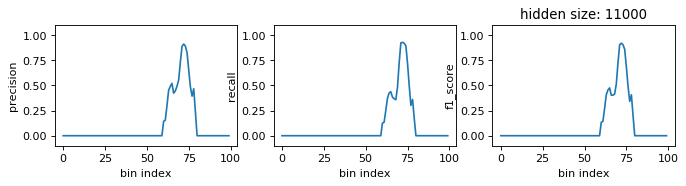

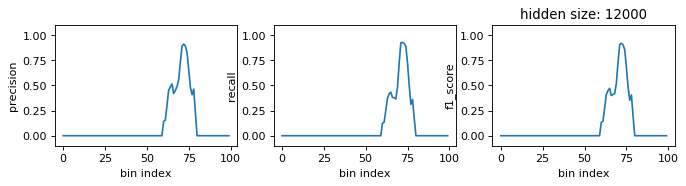

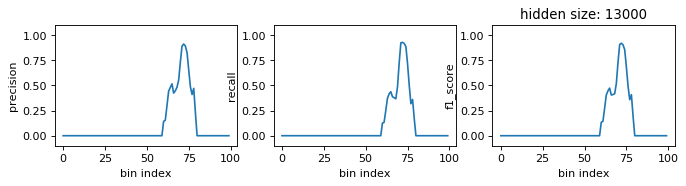

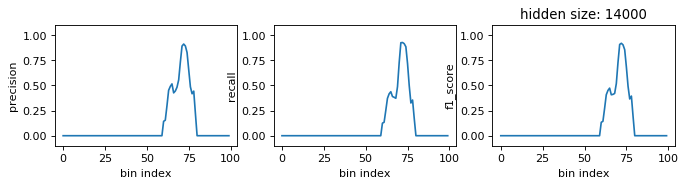

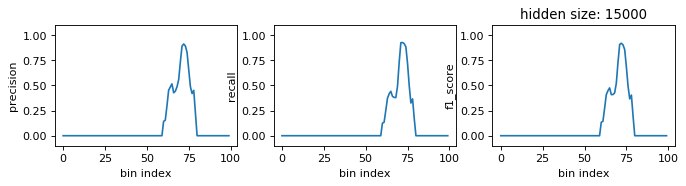

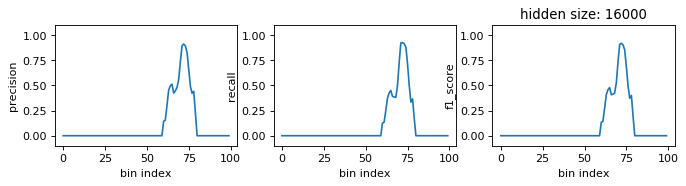

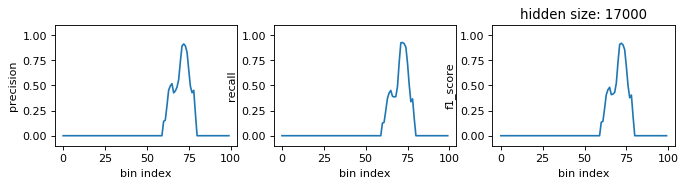

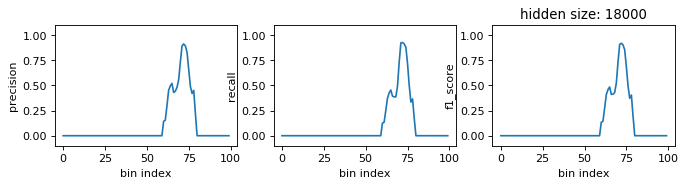

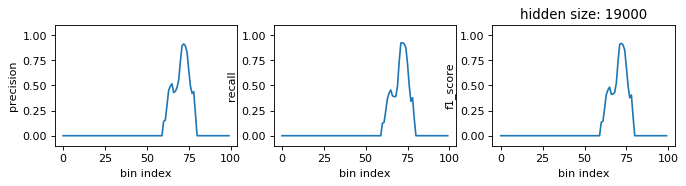

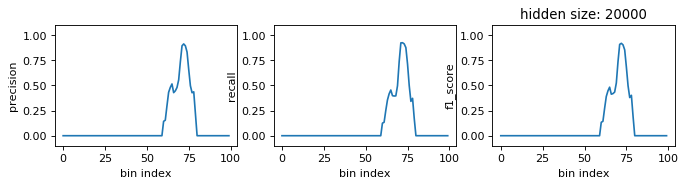

In [401]:
avg_precision_list, avg_recall_list, avg_f1_list = compute_prec_recall_curves(prediction_map)

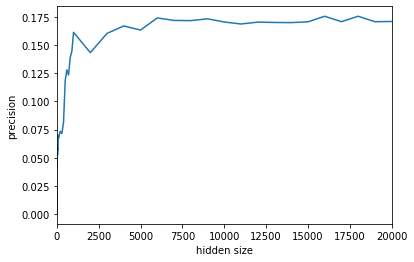

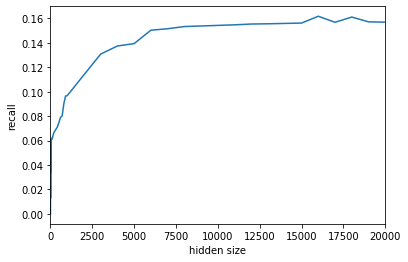

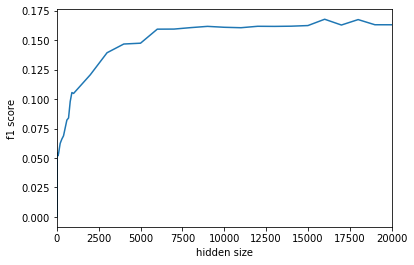

In [22]:
plt.plot(hidden_sizes, avg_precision_list)
plt.xlabel("hidden size")
plt.ylabel("precision")
plt.xlim((0, 20000))
plt.show()

plt.plot(hidden_sizes, avg_recall_list)
plt.xlabel("hidden size")
plt.ylabel("recall")
plt.xlim((0, 20000))
plt.show()

plt.plot(hidden_sizes, avg_f1_list)
plt.xlabel("hidden size")
plt.ylabel("f1 score")
plt.xlim((0, 20000))
plt.show()

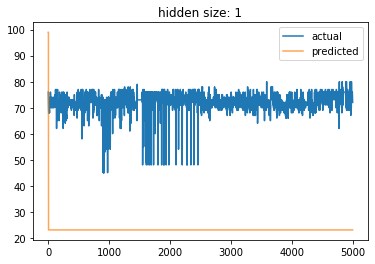

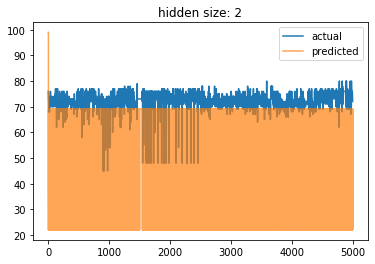

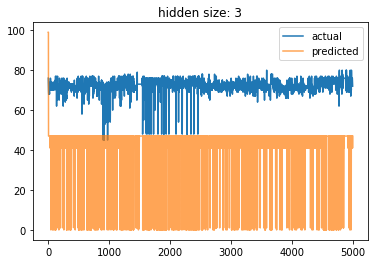

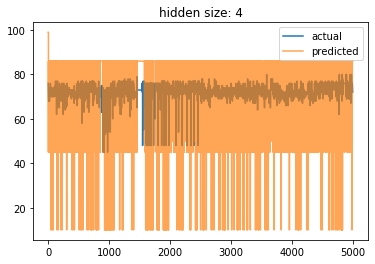

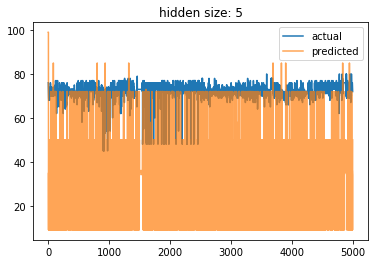

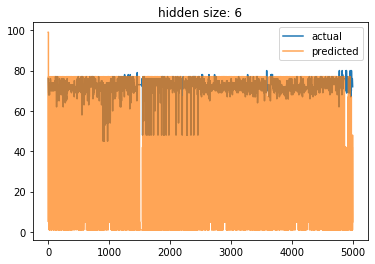

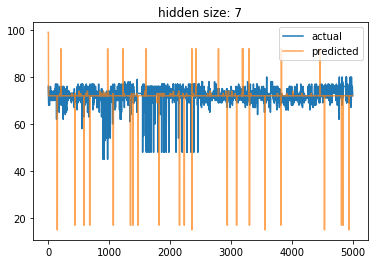

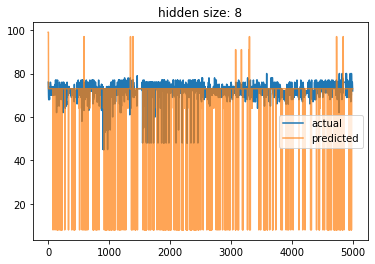

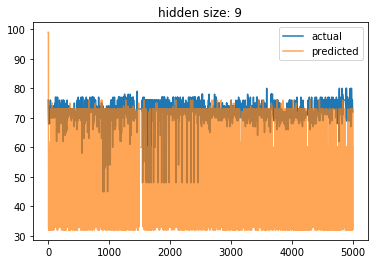

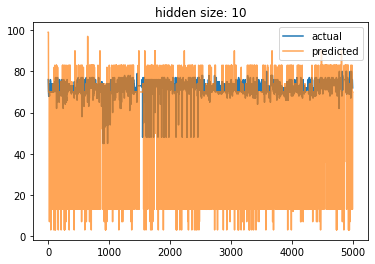

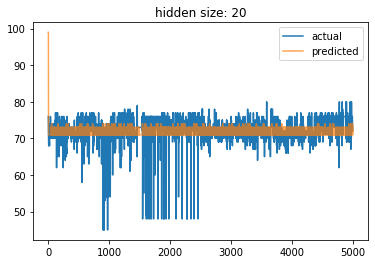

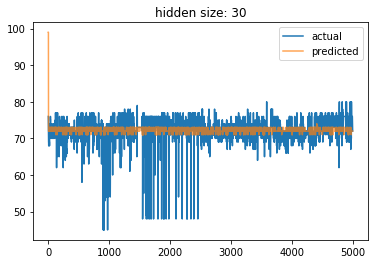

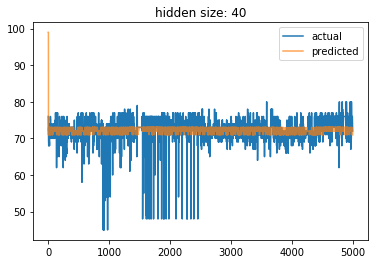

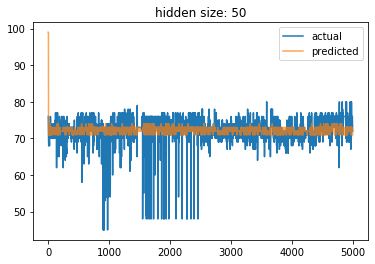

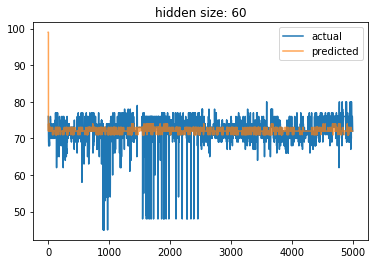

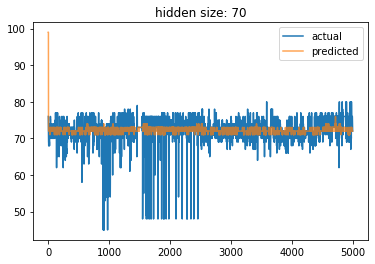

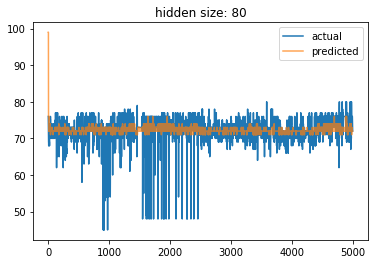

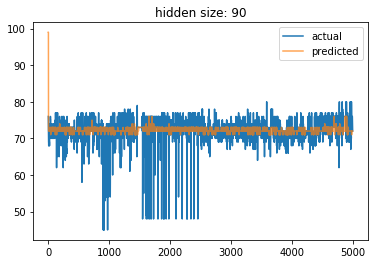

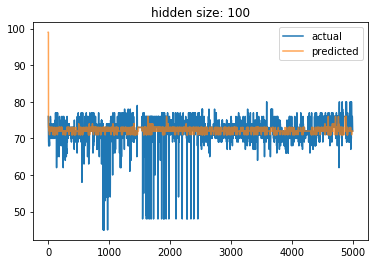

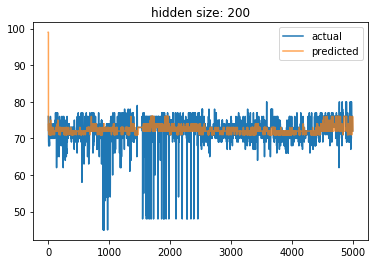

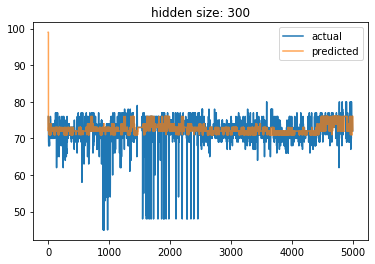

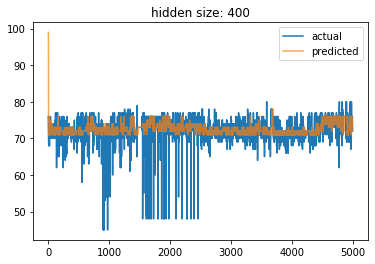

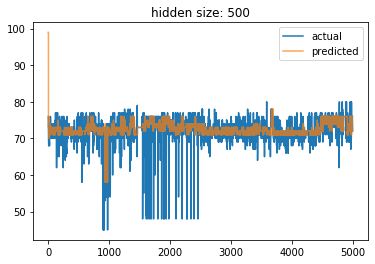

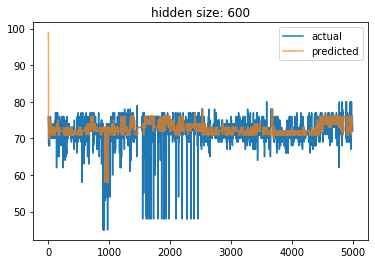

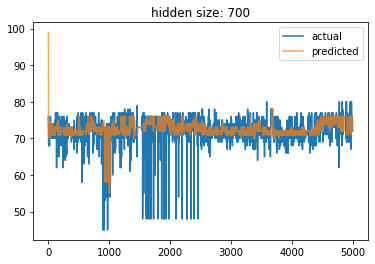

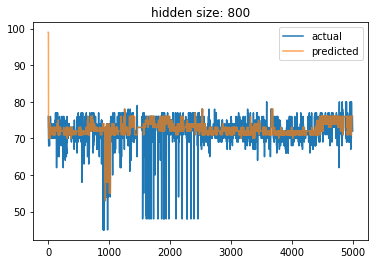

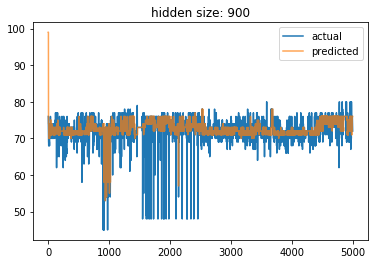

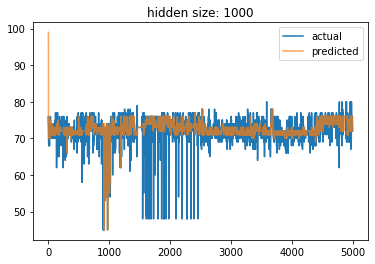

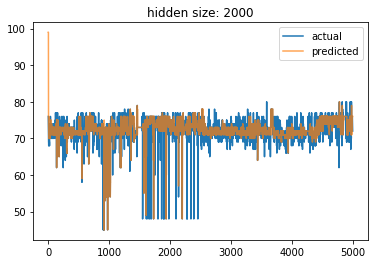

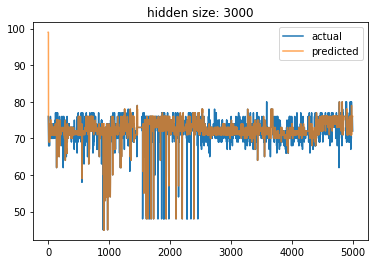

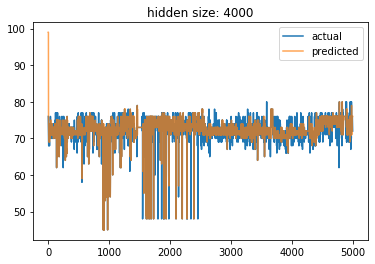

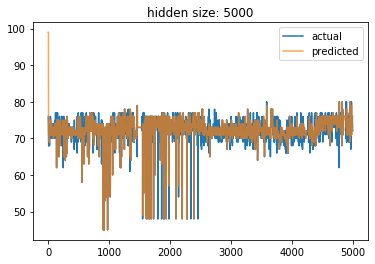

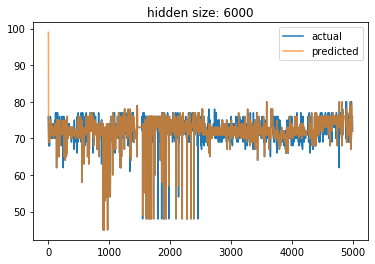

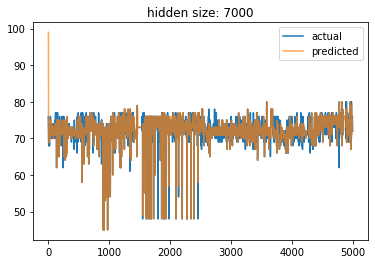

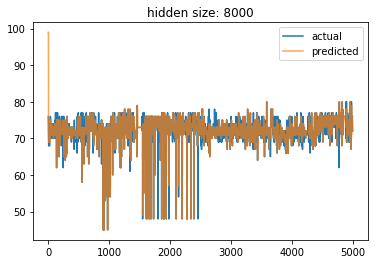

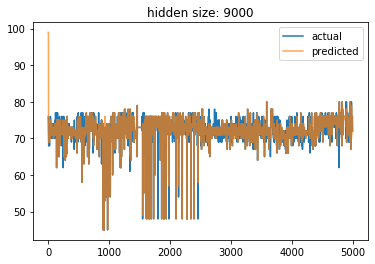

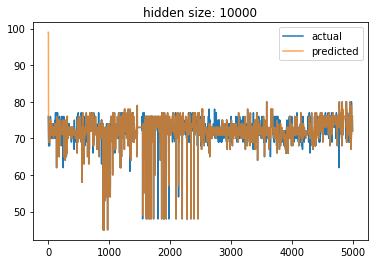

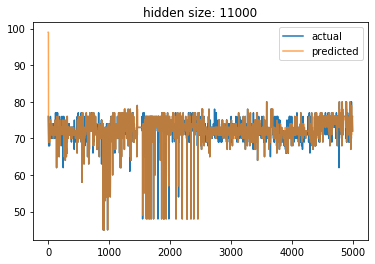

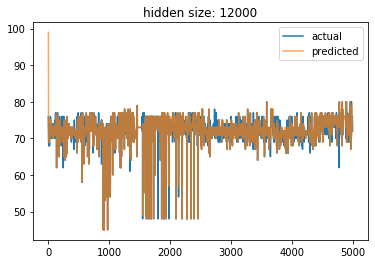

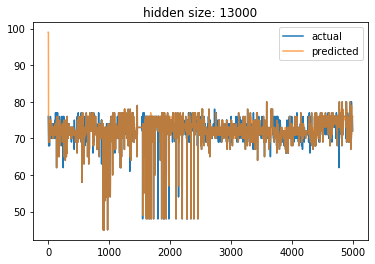

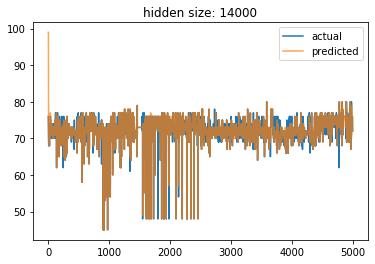

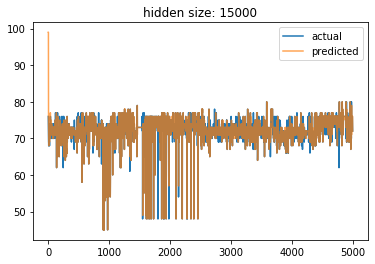

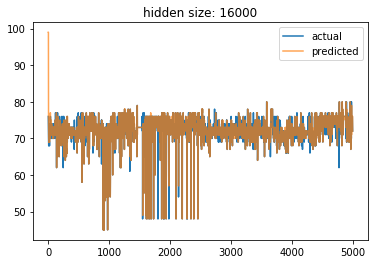

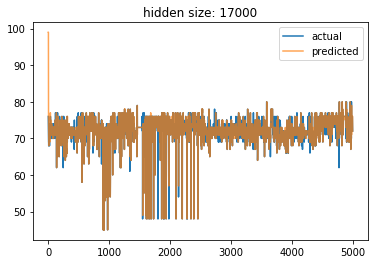

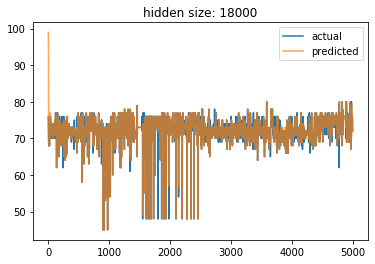

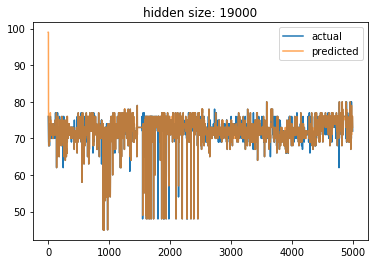

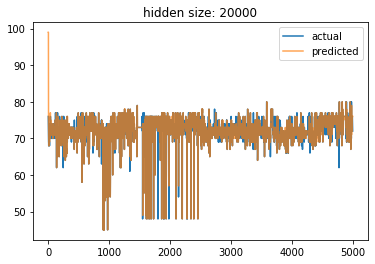

In [23]:
trace = plot_actual_predicted(trace_name, "hotspot")

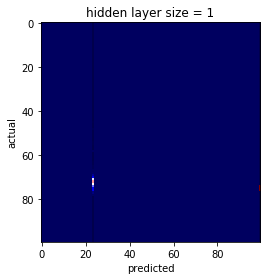

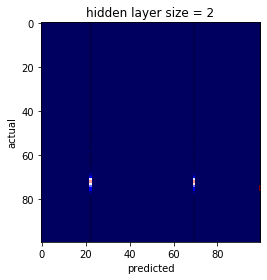

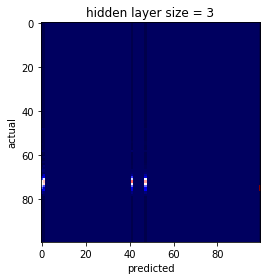

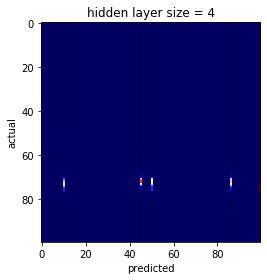

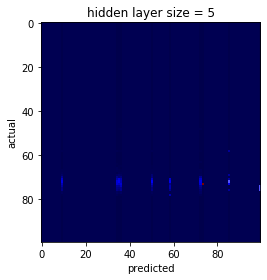

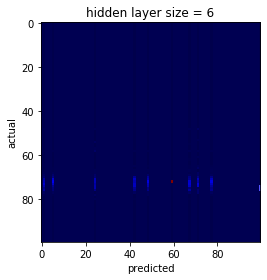

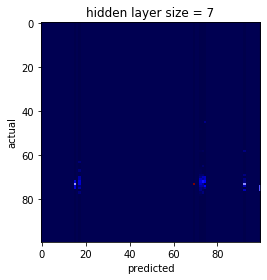

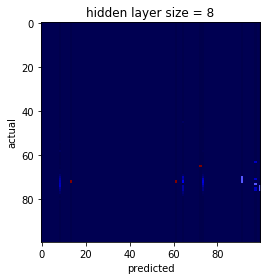

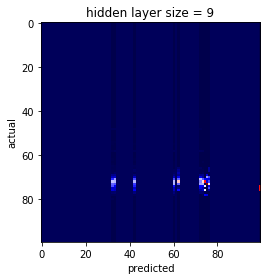

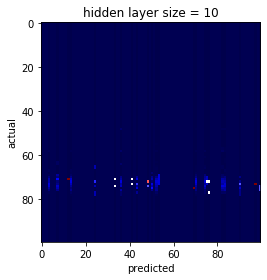

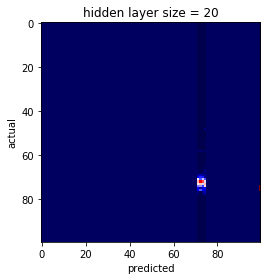

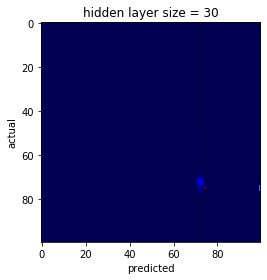

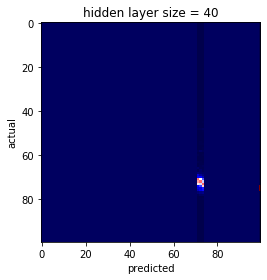

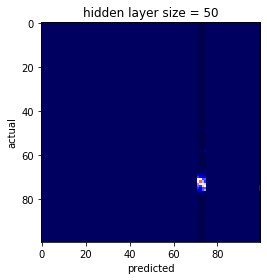

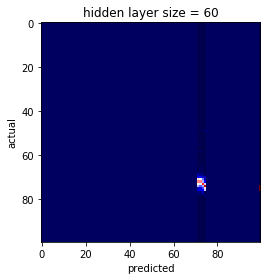

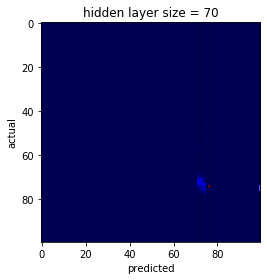

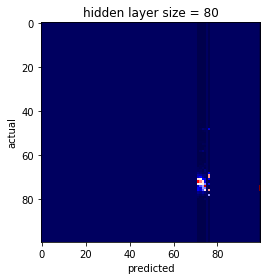

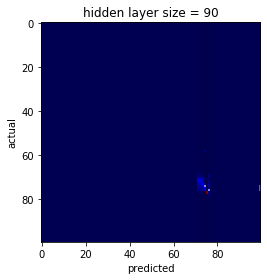

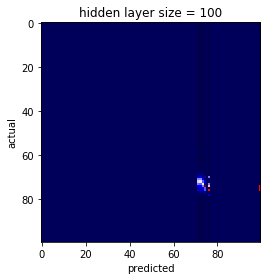

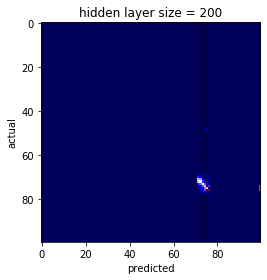

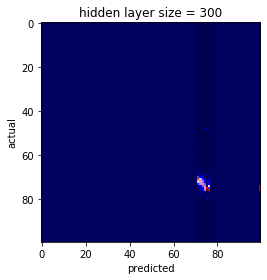

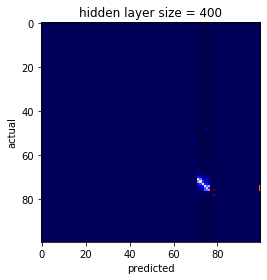

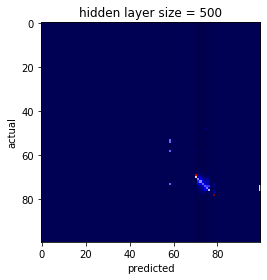

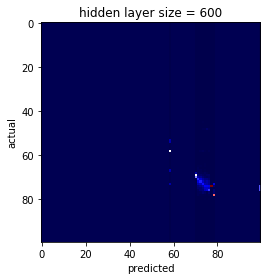

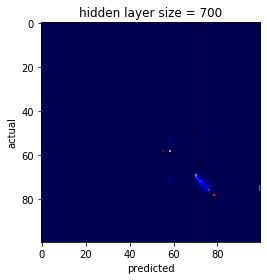

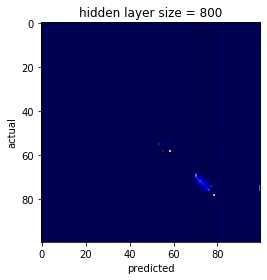

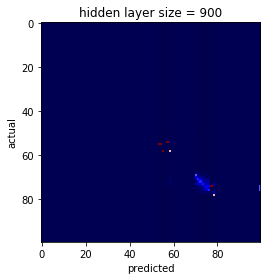

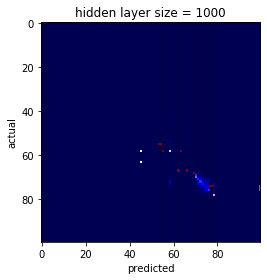

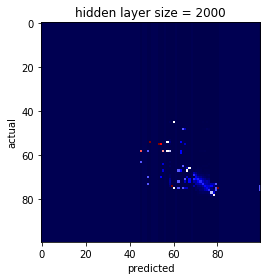

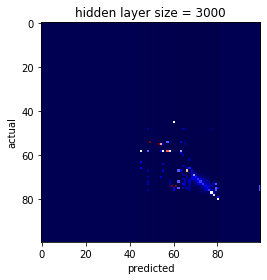

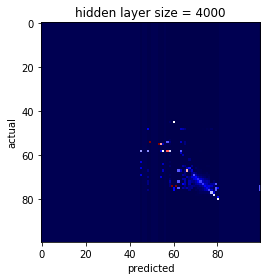

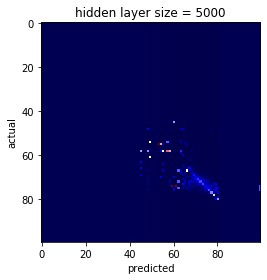

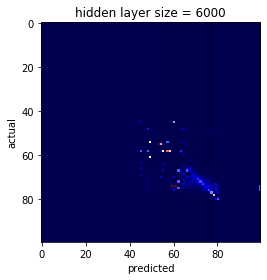

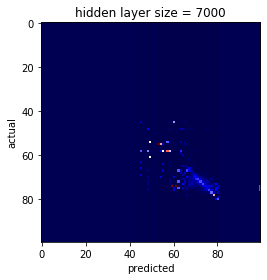

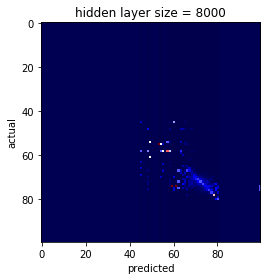

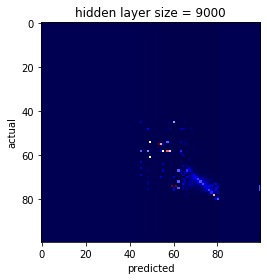

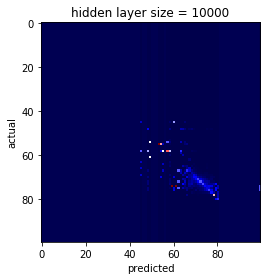

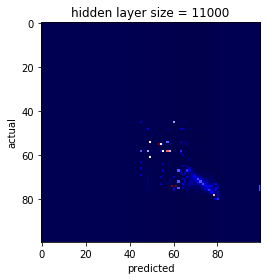

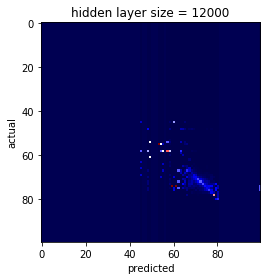

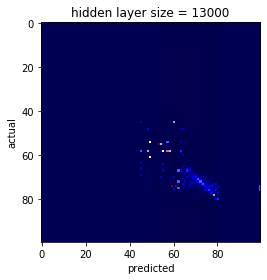

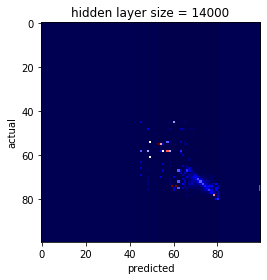

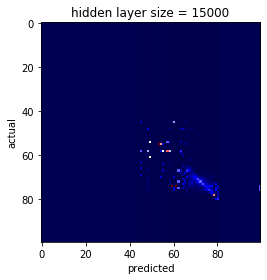

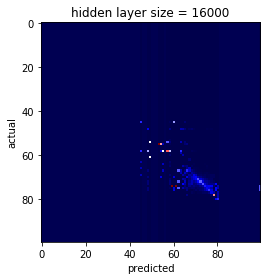

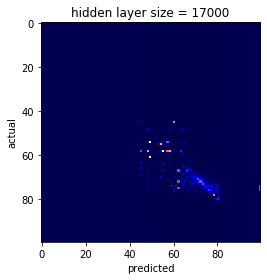

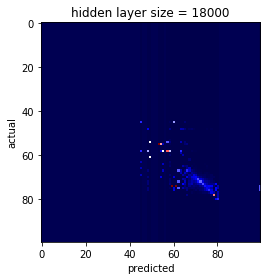

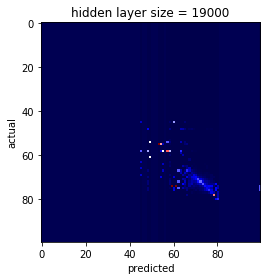

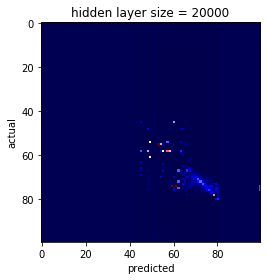

In [24]:
prediction_map = get_heatmaps(trace_name, trace, predictions, jvm="hotspot")

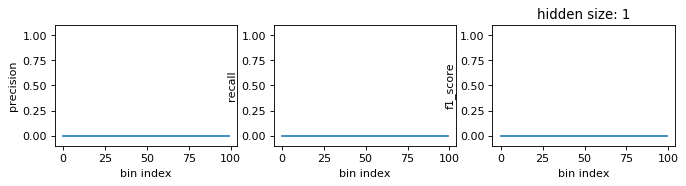

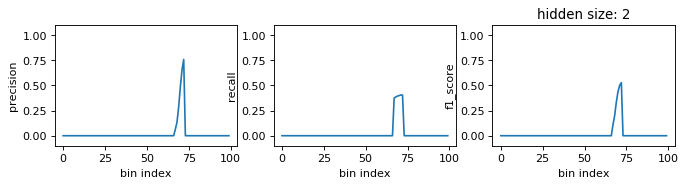

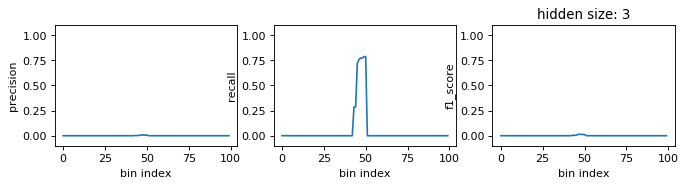

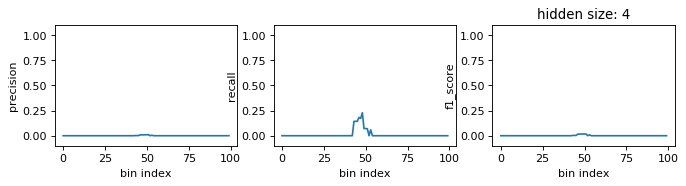

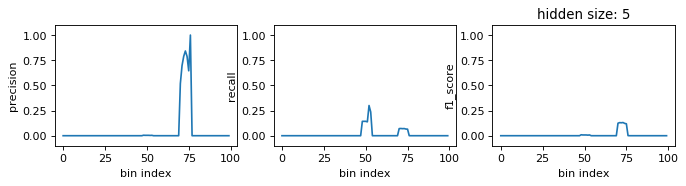

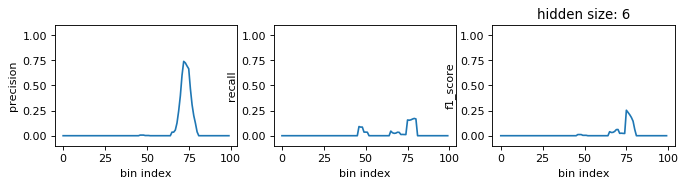

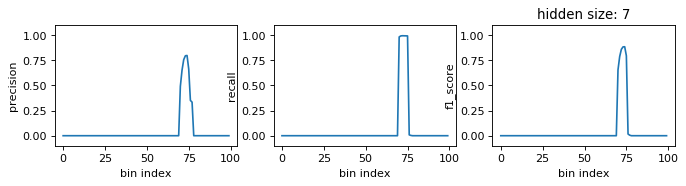

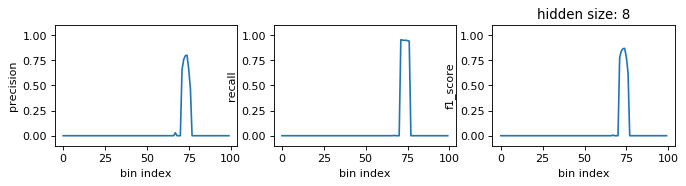

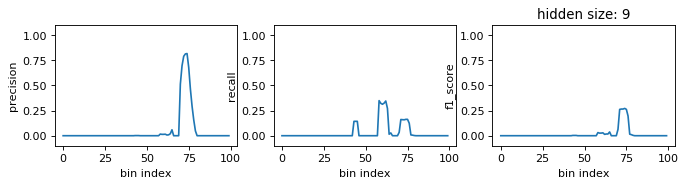

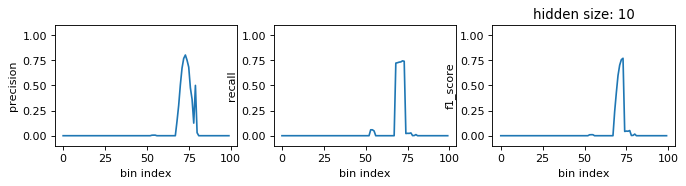

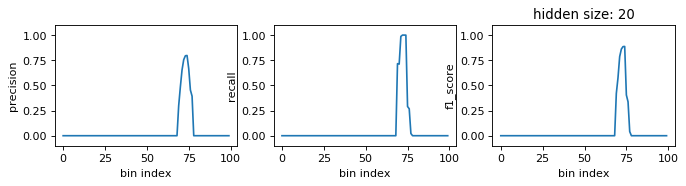

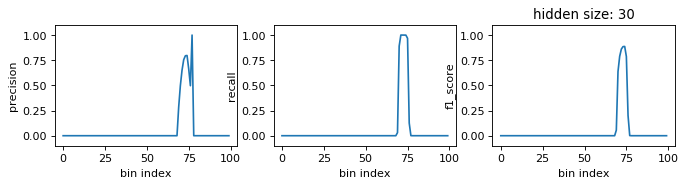

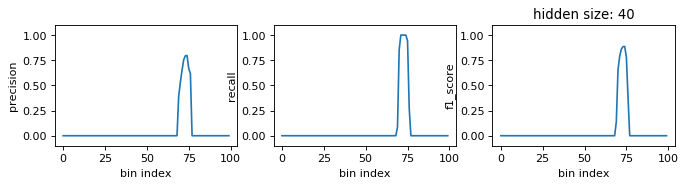

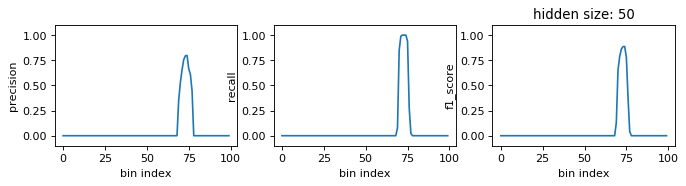

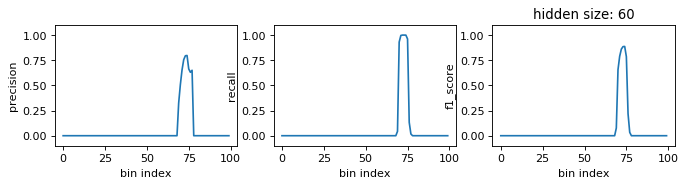

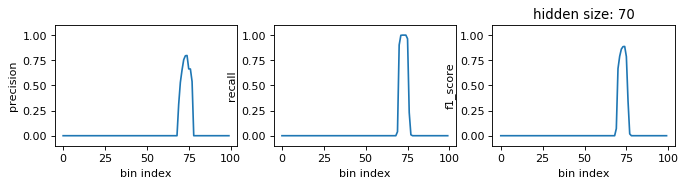

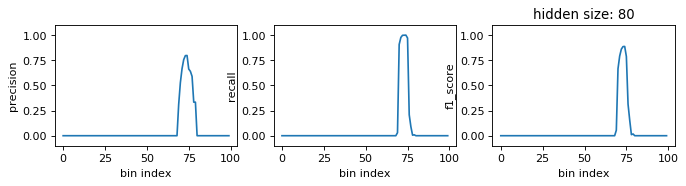

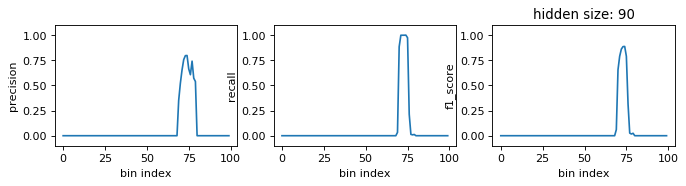

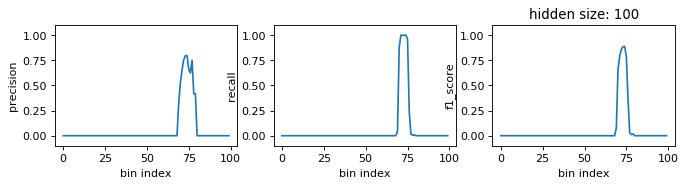

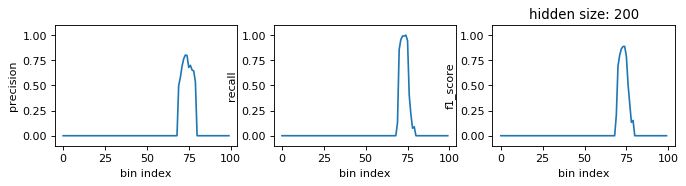

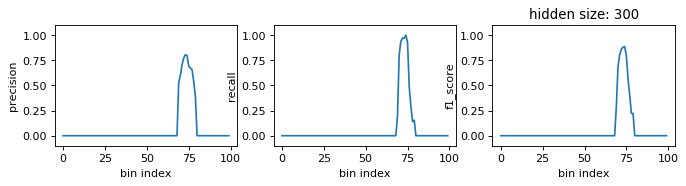

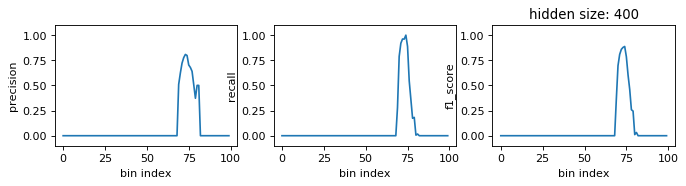

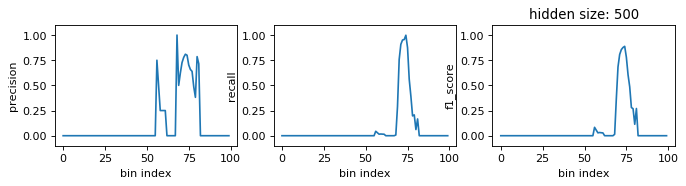

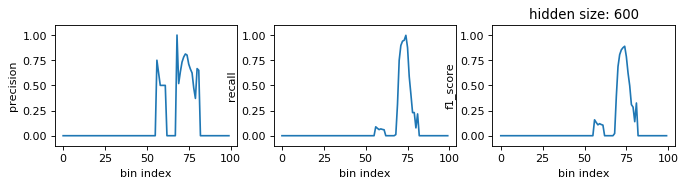

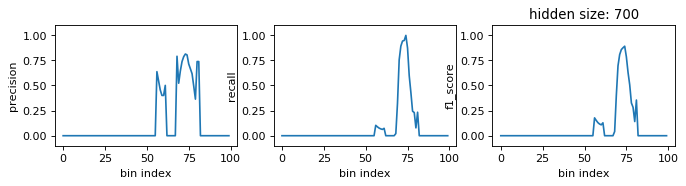

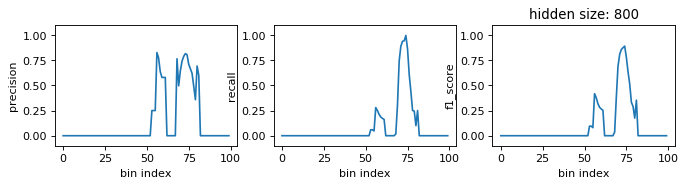

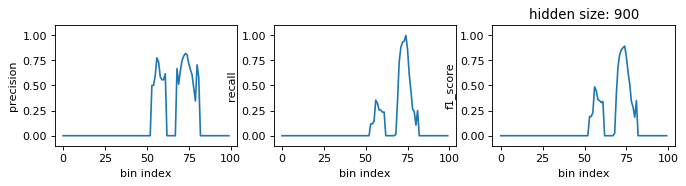

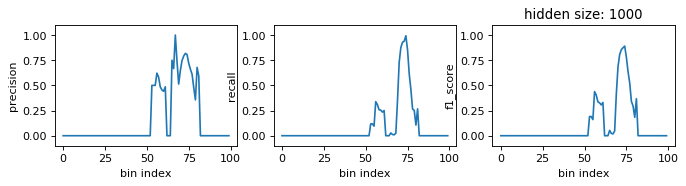

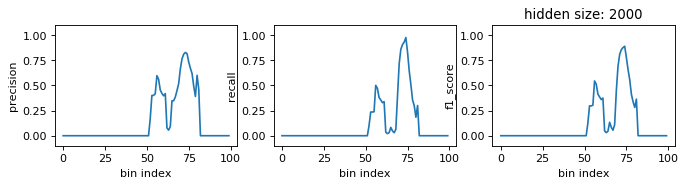

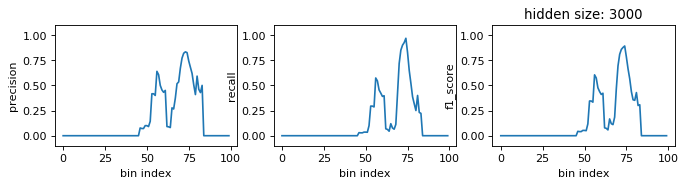

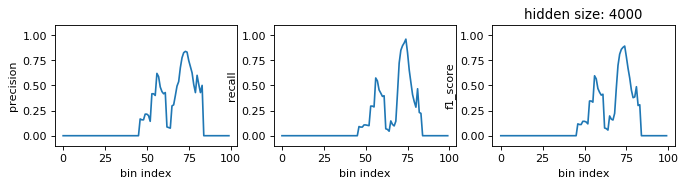

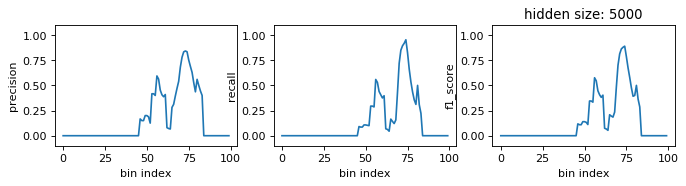

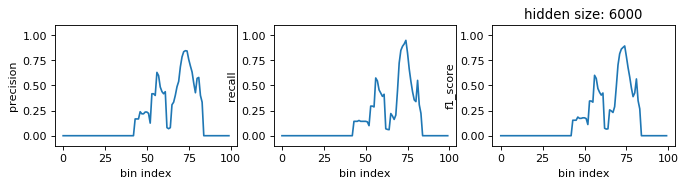

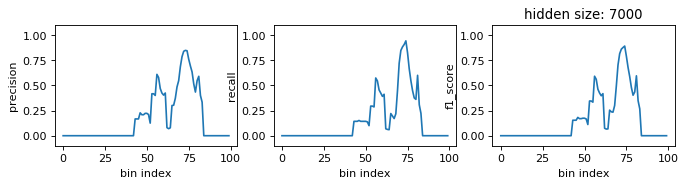

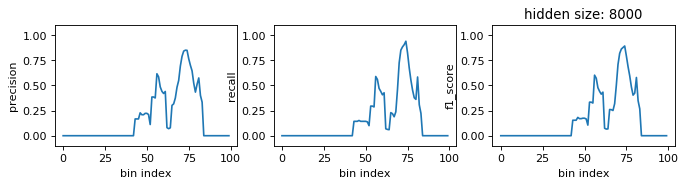

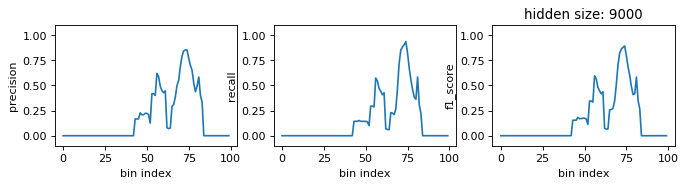

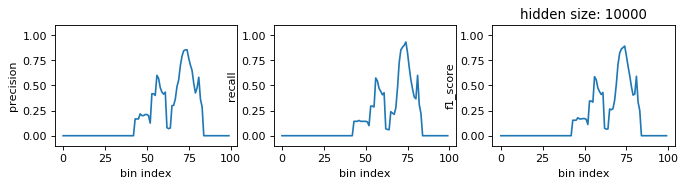

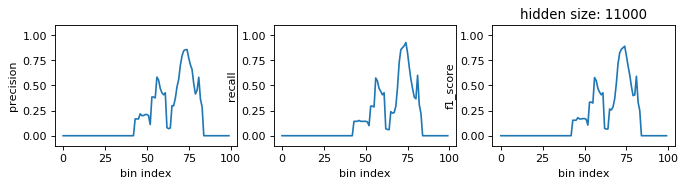

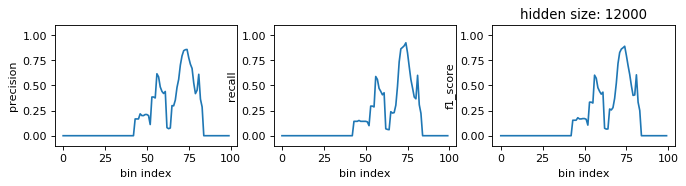

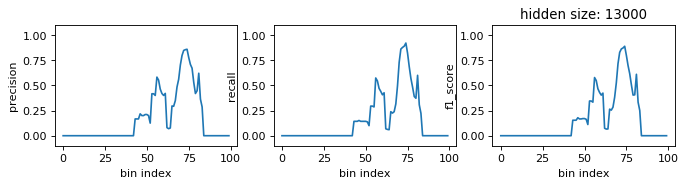

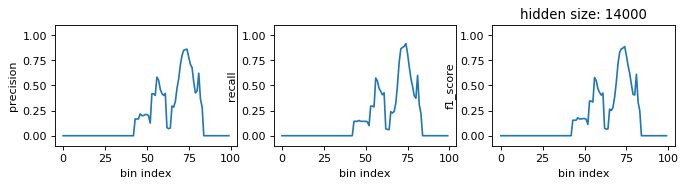

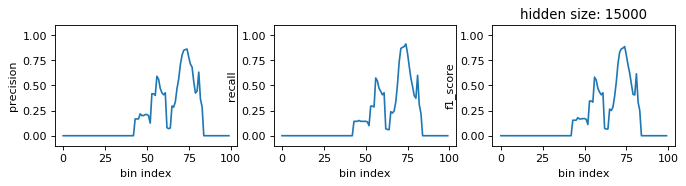

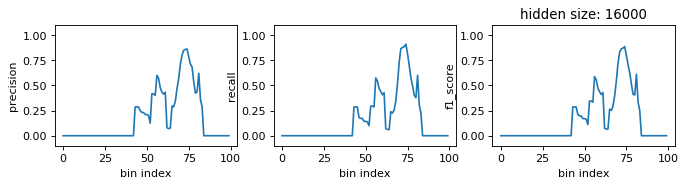

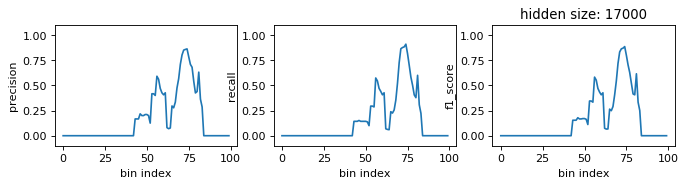

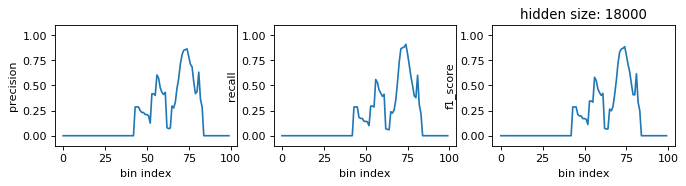

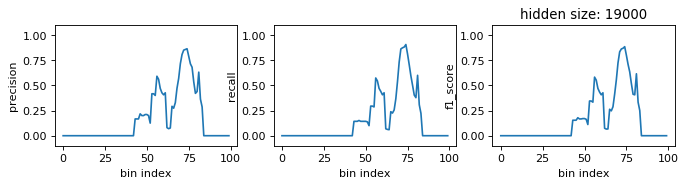

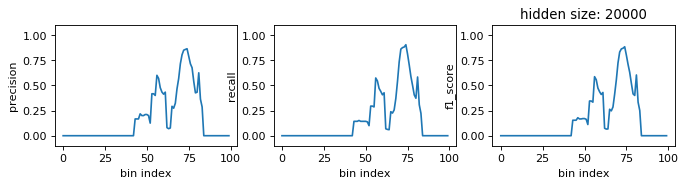

In [25]:
avg_precision_list, avg_recall_list, avg_f1_list = compute_prec_recall_curves(prediction_map)

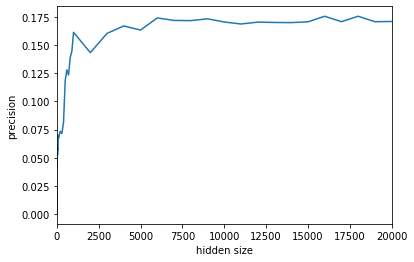

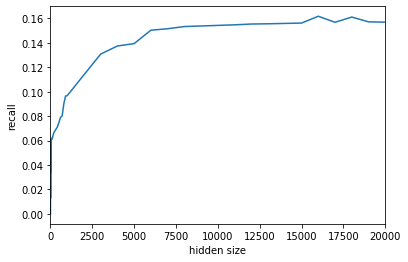

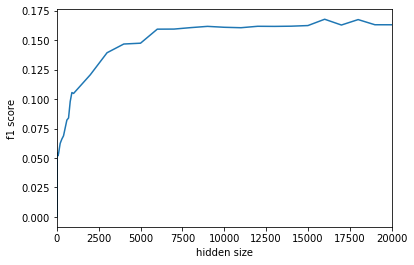

In [27]:
plt.plot(hidden_sizes, avg_precision_list)
plt.xlabel("hidden size")
plt.ylabel("precision")
plt.xlim((0, 20000))
plt.show()

plt.plot(hidden_sizes, avg_recall_list)
plt.xlabel("hidden size")
plt.ylabel("recall")
plt.xlim((0, 20000))
plt.show()

plt.plot(hidden_sizes, avg_f1_list)
plt.xlabel("hidden size")
plt.ylabel("f1 score")
plt.xlim((0, 20000))
plt.show()